In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from netCDF4 import num2date
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap as basemap
import getpass
import gsw

# Canarias

## Leer datos crudos (ARGO)

In [2]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/ARGO/Canarias/Core/'

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/ARGO/Canarias/Core


In [3]:
%ls

df_T_S_final.csv


In [4]:
import datetime as dt
ds_final=pd.read_csv('df_T_S_final.csv',sep=',')
ds_final['Fecha']=pd.to_datetime(ds_final['Fecha'])
ds_final['Year']= ds_final['Fecha'].dt.year
ds_final['Month']= ds_final['Fecha'].dt.month
ds_final['Day']= ds_final['Fecha'].dt.day
print(ds_final.shape)
ds_final.head()

(3691469, 14)


Fecha     Lon        Lat  Pres  Pres_Adj       Temp  \
0 2003-01-05 19:59:22 -12.433  35.373001  10.0      10.0  17.559999   
1 2003-01-05 19:59:22 -12.433  35.373001  20.0      20.0  17.556000   
2 2003-01-05 19:59:22 -12.433  35.373001  30.0      30.0  17.552000   
3 2003-01-05 19:59:22 -12.433  35.373001  40.0      40.0  17.554001   
4 2003-01-05 19:59:22 -12.433  35.373001  50.0      50.0  17.556000   

    Temp_Adj        Sal    Sal_Adj  Ciclo       Id  Year  Month  Day  
0  17.559999  36.296001  36.296040     31  1900041  2003      1    5  
1  17.556000  36.296001  36.296040     31  1900041  2003      1    5  
2  17.552000  36.299999  36.299965     31  1900041  2003      1    5  
3  17.554001  36.299999  36.299992     31  1900041  2003      1    5  
4  17.556000  36.299999  36.299984     31  1900041  2003      1    5

In [5]:
print(ds_final.shape)
df_perfil= ds_final[['Fecha','Lon','Lat','Ciclo','Month']]
df_perfil = df_perfil.drop_duplicates(subset = ['Fecha','Lon','Lat','Ciclo','Month'])
print(df_perfil.shape)
df_perfil.head()

(3691469, 14)
(28699, 5)


Fecha     Lon        Lat  Ciclo  Month
0   2003-01-05 19:59:22 -12.433  35.373001     31      1
34  2003-09-04 02:30:45 -11.675  36.362000     55      9
68  2003-10-04 05:11:35 -13.180  36.423000     58     10
102 2003-10-14 04:59:05 -13.620  35.443001     59     10
136 2003-10-24 14:28:16 -12.752  35.314999     60     10

In [6]:
for i in range(4):
  if i==0: # DJF
    mes= df_perfil[(df_perfil.Month == 12)|(df_perfil.Month == 1)|(df_perfil.Month == 2)]
    print('DJF: ', len(mes.Ciclo.unique()))
  elif i ==1: # MAM
    mes= df_perfil[(df_perfil.Month == 3)|(df_perfil.Month == 4)|(df_perfil.Month == 5)]
    print('MAM: ', len(mes.Ciclo.unique()))
  elif i ==2: # JJA
    mes= df_perfil[(df_perfil.Month == 6)|(df_perfil.Month == 7)|(df_perfil.Month == 8)]
    print('JJA: ', len(mes.Ciclo.unique()))
  else: # SON
    mes= df_perfil[(df_perfil.Month == 9)|(df_perfil.Month == 10)|(df_perfil.Month == 11)]
    print('SON: ', len(mes.Ciclo.unique()))

DJF:  281
MAM:  286
JJA:  442
SON:  284


In [7]:
# Conteos por mes
for i in range(1,13,1):
  mes= df_perfil[df_perfil.Month == i]
  print('Mes: ',i, len(mes.Ciclo.unique()))

Mes:  1 235
Mes:  2 237
Mes:  3 246
Mes:  4 242
Mes:  5 246
Mes:  6 267
Mes:  7 346
Mes:  8 333
Mes:  9 242
Mes:  10 241
Mes:  11 251
Mes:  12 236


## Leer datos Producto reanalisis

In [8]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_VALIDACION_MLD/Canarias/'
reanal=xr.open_dataset('GLOBAL_REANALYSIS_PHY_MLD.nc')#.groupby("time.season").mean()
reanal=reanal.rename({'longitude': 'lon','latitude': 'lat'})
reanal

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_VALIDACION_MLD/Canarias


<xarray.Dataset>
Dimensions:  (lon: 81, lat: 121, depth: 40, month: 12)
Coordinates:
  * lon      (lon) float32 -25.0 -24.75 -24.5 -24.25 ... -5.75 -5.5 -5.25 -5.0
  * lat      (lat) float32 15.0 15.25 15.5 15.75 16.0 ... 44.25 44.5 44.75 45.0
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SA       (month, depth, lat, lon) float64 ...
    CT       (month, depth, lat, lon) float64 ...
    D        (month, depth, lat, lon) float64 ...

**Filtro de 0 -600 dbar** (ARGO)

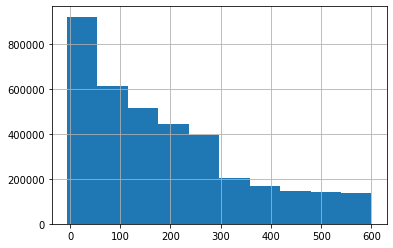

In [9]:
ds_final = ds_final[ds_final['Pres_Adj']< 600]
ds_final.Pres_Adj.hist()

In [10]:
# crear dataframes para cada mes a analizar, agrupar y sacar la media para evitar duplicados
lista_dfs=[]
for i in range(4): # 12
  if i ==0: # DJF
    mes_i= ds_final[(ds_final.Month ==12)|(ds_final.Month ==1)|(ds_final.Month ==2)]
    mes_i=mes_i[['Lon','Lat','Pres_Adj','Temp_Adj','Sal_Adj','Ciclo','Id']].groupby(by=['Lon','Lat','Ciclo','Pres_Adj','Id']).mean()
    mes_i=mes_i.reset_index()
    # Calculo de salinidad absoluta
    mes_i['SA']=gsw.SA_from_SP(SP=mes_i.Sal_Adj,p=mes_i.Pres_Adj, lon=mes_i.Lon,lat=mes_i.Lat)
    # Calculo Temperatura potencial
    mes_i['PT']=gsw.pt_from_t(SA=mes_i.SA.values, t= mes_i.Temp_Adj.values,p=mes_i.Pres_Adj.values,p_ref= 10.1325)
    # Calculo de Temperatura conservativa
    mes_i['CT']=gsw.CT_from_pt(SA= mes_i.SA,pt=mes_i.PT)
    # Calcular la densidad potencial
    mes_i['D']= gsw.density.rho(SA=mes_i.SA.values, CT=mes_i.CT.values,p= 10.25)-1000
    print('DJF: ', '- Dimension:',mes_i.shape)
    lista_dfs.append(mes_i)
  elif i ==1: # MAM
    mes_i= ds_final[(ds_final.Month ==3)|(ds_final.Month ==4)|(ds_final.Month ==5)]
    mes_i=mes_i[['Lon','Lat','Pres_Adj','Temp_Adj','Sal_Adj','Ciclo','Id']].groupby(by=['Lon','Lat','Ciclo','Pres_Adj','Id']).mean()
    mes_i=mes_i.reset_index()
    # Calculo de salinidad absoluta
    mes_i['SA']=gsw.SA_from_SP(SP=mes_i.Sal_Adj,p=mes_i.Pres_Adj, lon=mes_i.Lon,lat=mes_i.Lat)
    # Calculo Temperatura potencial
    mes_i['PT']=gsw.pt_from_t(SA=mes_i.SA.values, t= mes_i.Temp_Adj.values,p=mes_i.Pres_Adj.values,p_ref= 10.1325)
    # Calculo de Temperatura conservativa
    mes_i['CT']=gsw.CT_from_pt(SA= mes_i.SA,pt=mes_i.PT)
    # Calcular la densidad potencial
    mes_i['D']= gsw.density.rho(SA=mes_i.SA.values, CT=mes_i.CT.values,p= 10.25)-1000
    print('MAM: ', '- Dimension:',mes_i.shape)
    lista_dfs.append(mes_i)
  elif i ==2: # JJA
    mes_i= ds_final[(ds_final.Month ==6)|(ds_final.Month ==7)|(ds_final.Month ==8)]
    mes_i=mes_i[['Lon','Lat','Pres_Adj','Temp_Adj','Sal_Adj','Ciclo','Id']].groupby(by=['Lon','Lat','Ciclo','Pres_Adj','Id']).mean()
    mes_i=mes_i.reset_index()
    # Calculo de salinidad absoluta
    mes_i['SA']=gsw.SA_from_SP(SP=mes_i.Sal_Adj,p=mes_i.Pres_Adj, lon=mes_i.Lon,lat=mes_i.Lat)
    # Calculo Temperatura potencial
    mes_i['PT']=gsw.pt_from_t(SA=mes_i.SA.values, t= mes_i.Temp_Adj.values,p=mes_i.Pres_Adj.values,p_ref= 10.1325)
    # Calculo de Temperatura conservativa
    mes_i['CT']=gsw.CT_from_pt(SA= mes_i.SA,pt=mes_i.PT)
    # Calcular la densidad potencial
    mes_i['D']= gsw.density.rho(SA=mes_i.SA.values, CT=mes_i.CT.values,p= 10.25)-1000
    print('JJA: ', '- Dimension:',mes_i.shape)
    lista_dfs.append(mes_i)
  else: #SON
    mes_i= ds_final[(ds_final.Month ==9)|(ds_final.Month ==10)|(ds_final.Month ==11)]
    mes_i=mes_i[['Lon','Lat','Pres_Adj','Temp_Adj','Sal_Adj','Ciclo','Id']].groupby(by=['Lon','Lat','Ciclo','Pres_Adj','Id']).mean()
    mes_i=mes_i.reset_index()
    # Calculo de salinidad absoluta
    mes_i['SA']=gsw.SA_from_SP(SP=mes_i.Sal_Adj,p=mes_i.Pres_Adj, lon=mes_i.Lon,lat=mes_i.Lat)
    # Calculo Temperatura potencial
    mes_i['PT']=gsw.pt_from_t(SA=mes_i.SA.values, t= mes_i.Temp_Adj.values,p=mes_i.Pres_Adj.values,p_ref= 10.1325)
    # Calculo de Temperatura conservativa
    mes_i['CT']=gsw.CT_from_pt(SA= mes_i.SA,pt=mes_i.PT)
    # Calcular la densidad potencial
    mes_i['D']= gsw.density.rho(SA=mes_i.SA.values, CT=mes_i.CT.values,p= 10.25)-1000
    print('SON: ', '- Dimension:',mes_i.shape)
    lista_dfs.append(mes_i)
print(len(lista_dfs))

DJF:  - Dimension: (504304, 11)
MAM:  - Dimension: (517953, 11)
JJA:  - Dimension: (649266, 11)
SON:  - Dimension: (543115, 11)
4


In [11]:
# Funcion para sacar el numero de perfiles por cada mes
import numpy as np
import matplotlib.pyplot as plt
def cantidad_perfiles_mes(data):
  x = data.Lon;y = data.Lat;
  # Creacion de la grilla
  gridx = np.arange(-25,-5+1,1) # valores de lon
  #print(gridx.shape);print(gridx);
  gridy = np.arange(15,45+1,1)
  #print(gridy.shape);print(gridy);
  grid, _, _ = np.histogram2d(x, y, bins=[gridx, gridy]);
  #print(grid.shape)
  # Ponerlo en el mismo sentido para que quede alineado con Chile
  grid1=np.flip(grid.T, axis=0) # Izquierda°-85W , derecha -70°W, arriba -15°S, abajo -45°S
  x1= np.arange(-25+0.5, -5+0.5,1);y1= list(np.arange(15+0.5,45+0.5,1));y1=y1[::-1];y1= np.array(y1);
  #print(x1.shape);print(y1.shape)
  # Reemplazar 0 por nan
  grid1[grid1 == 0] = np.nan
  return grid1

In [12]:
lista_conteos=[]
for i in range(len(lista_dfs)):
  lista_conteos.append(cantidad_perfiles_mes(lista_dfs[i]))

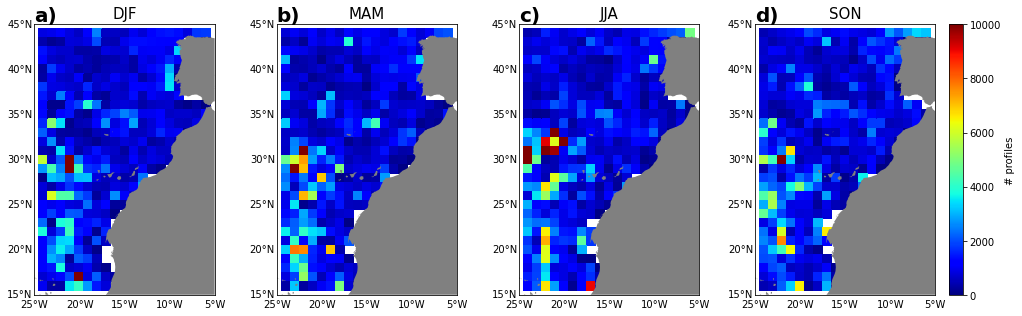

In [13]:
import string
ticks= np.array([0,2000, 4000, 6000, 8000, 10000]) #labels para el colorbar
x1= np.arange(-25+0.5, -5+0.5,1);y1= list(np.arange(15+0.5,45+0.5,1));y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.17
meses=['DJF','MAM','JJA','SON']
# atributos [left, bottom, width,height] en escala (0,1)
#list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
#        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
#        [0,0.4,w,h],[0.2,0.4,w,h],[0.4,0.4,w,h],[0.6,0.4,w,h],]
list_o =[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h]]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(len(lista_conteos))):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-25,llcrnrlat=15,urcrnrlon=-5,urcrnrlat=45, resolution ='h')
  x, y = m(x1, y1)
  z= lista_conteos[j]
  cmap= plt.get_cmap("jet")
  cs=m.pcolormesh(x1, y1, z,cmap='jet',shading='flat',latlon=True,vmin=0, vmax=10000)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(15,46,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-25,-20,-15,-10,-5],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('# profiles', rotation=90)

## Filtro si hay menos de 1000 perfiles

In [ ]:
lista_cont_fin=[]
for j in range(len(lista_conteos)):
  data= lista_conteos[j]
  data[data <1000]=np.nan
  lista_cont_fin.append(data)

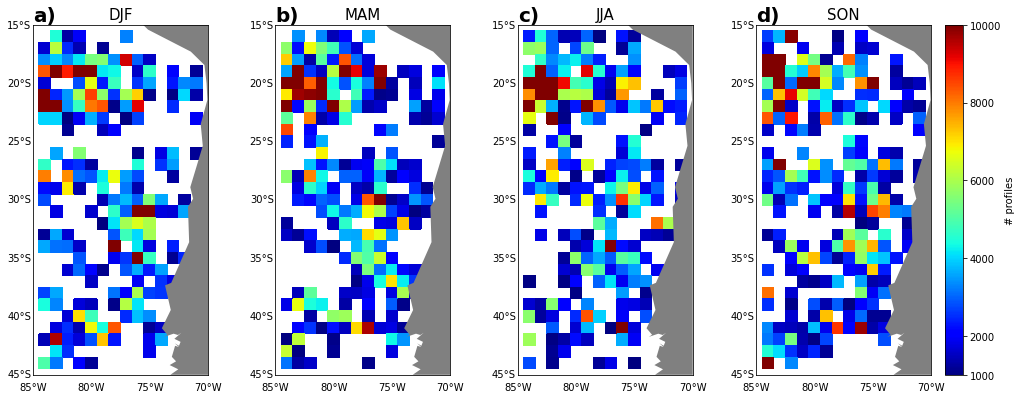

In [ ]:
import string
ticks= np.array([1000,2000, 4000, 6000, 8000, 10000]) #labels para el colorbar
x1= np.arange(-25+0.5, -5+0.5,1);y1= list(np.arange(15+0.5,45+0.5,1));y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.22
meses=['DJF','MAM','JJA','SON']
# atributos [left, bottom, width,height] en escala (0,1)
#list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
#        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
#        [0,0.4,w,h],[0.2,0.4,w,h],[0.4,0.4,w,h],[0.6,0.4,w,h],]
list_o =[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h]]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(len(lista_conteos))):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-85,llcrnrlat=-45,urcrnrlon=-70,urcrnrlat=-15, resolution ='c')
  x, y = m(x1, y1)
  z= lista_cont_fin[j]
  cmap= plt.get_cmap("jet")
  cs=m.pcolormesh(x1, y1, z,cmap='jet',shading='flat',latlon=True,vmin=1000, vmax=10000)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(-45,-14,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-85,-80,-75,-70],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('# profiles', rotation=90)

In [ ]:
# filtro DJF
DJF_filter= np.isnan(lista_cont_fin[0])
MAM_filter= np.isnan(lista_cont_fin[1])
JJA_filter= np.isnan(lista_cont_fin[2])
SON_filter= np.isnan(lista_cont_fin[3])

## Ejemplo de prueba para un mes (Interpolacion vertical Akima)

------------------------------------
Id : 3900224
Ciclo 144 ......................... Check
Ciclo 146 ......................... Check
Ciclo 147 ......................... Check
Ciclo 111 ......................... Check
Ciclo 148 ......................... Check
Ciclo 150 ......................... Check
Ciclo 149 ......................... Check
Ciclo 110 ......................... Check
Ciclo 109 ......................... Check
Ciclo 32 ......................... Check
Ciclo 31 ......................... Check
Ciclo 33 ......................... Check
Ciclo 34 ......................... Check
Ciclo 108 ......................... Check
Ciclo 30 ......................... Check
Ciclo 29 ......................... Check
Ciclo 188 ......................... Check
Ciclo 35 ......................... Check
Ciclo 28 ......................... Check
Ciclo 187 ......................... Check
Ciclo 27 ......................... Check
Ciclo 107 ......................... Check
Ciclo 186 .........................

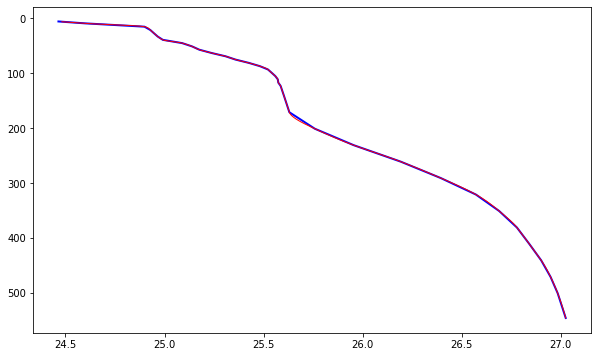

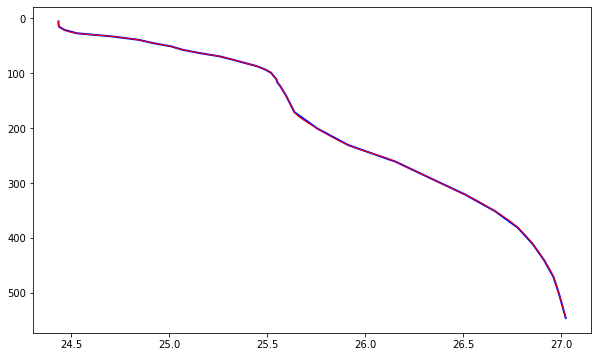

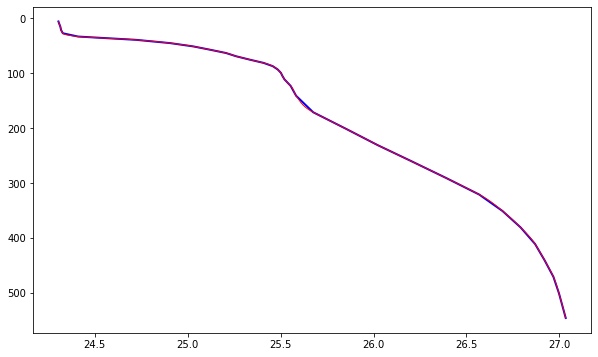

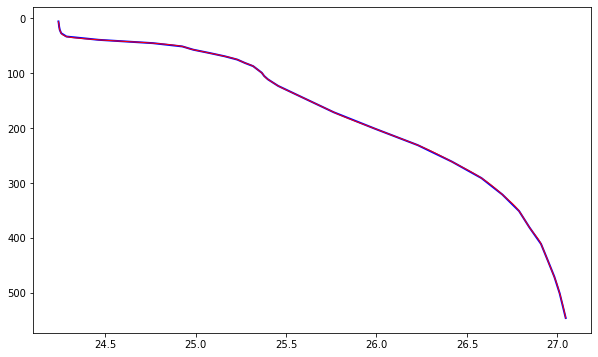

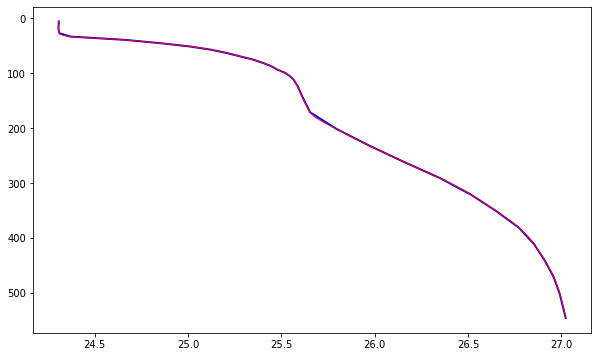

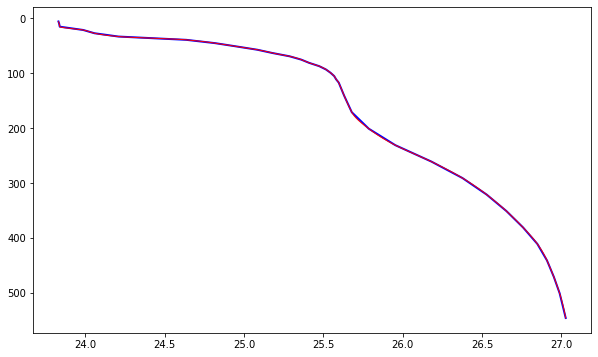

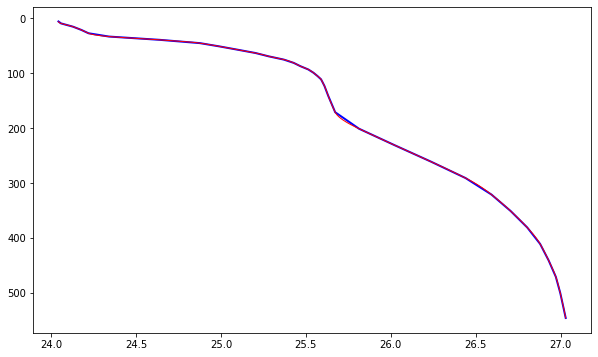

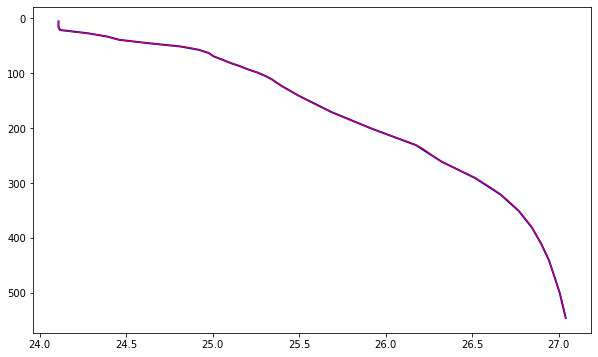

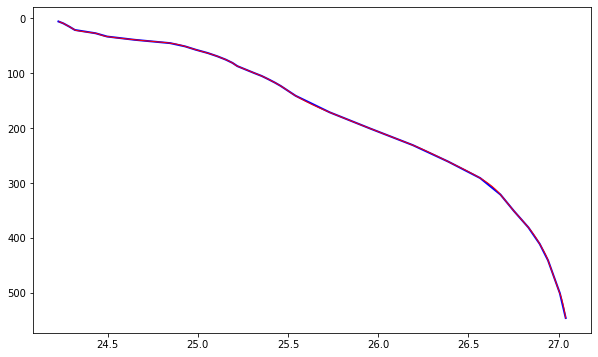

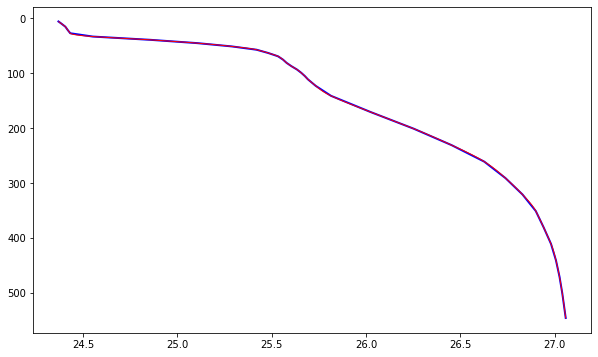

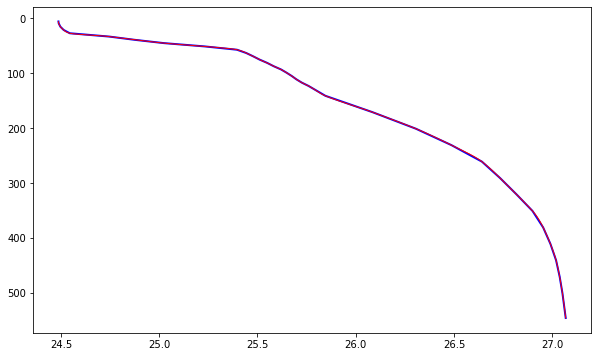

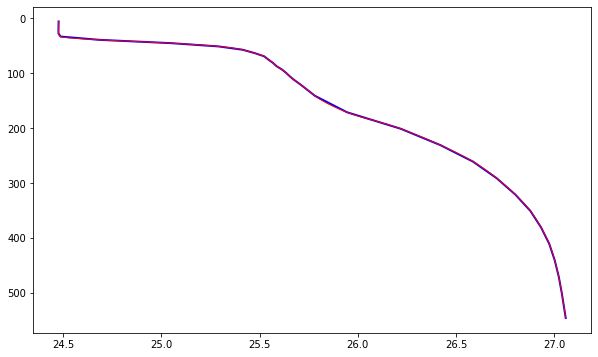

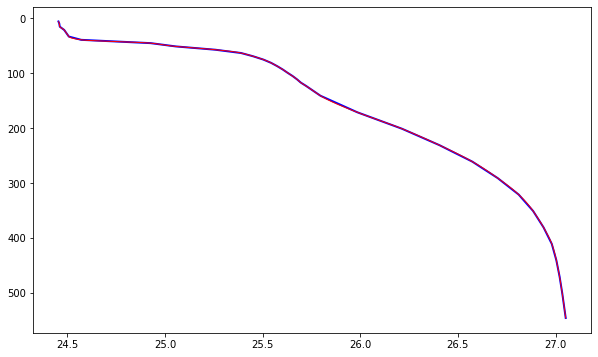

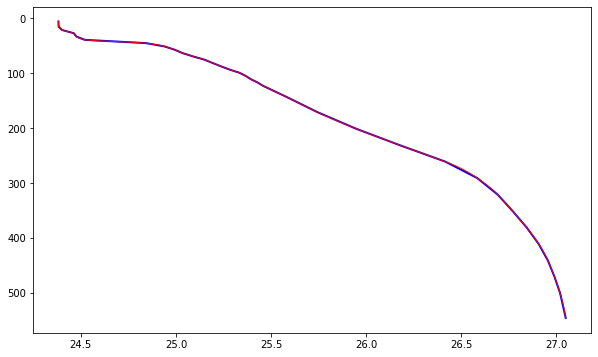

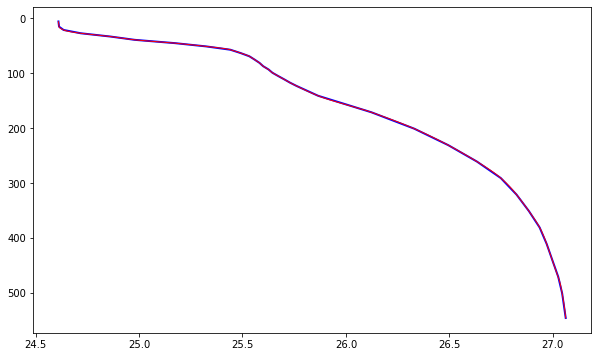

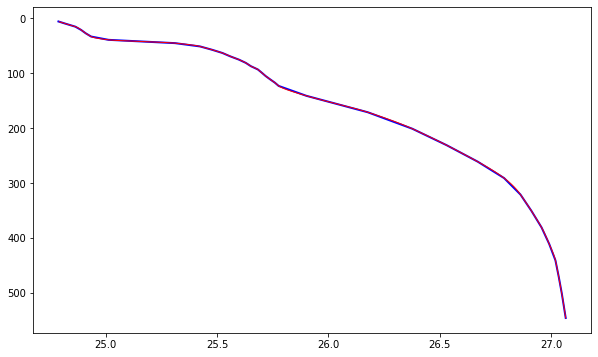

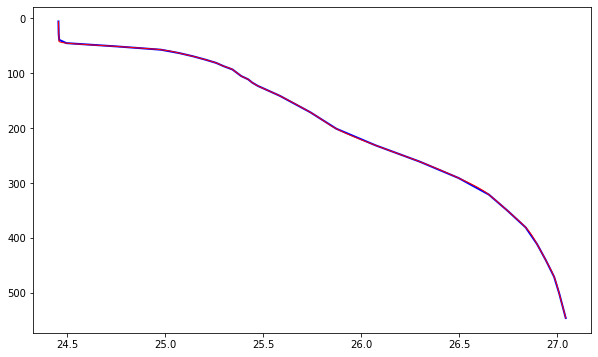

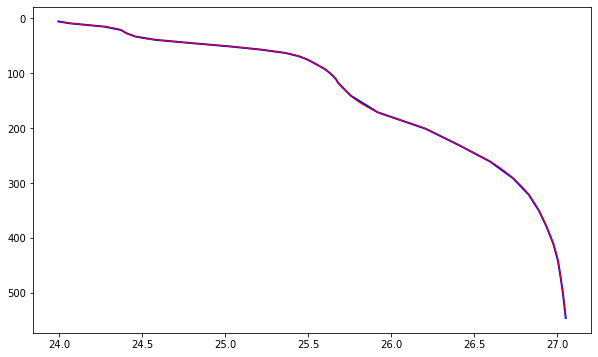

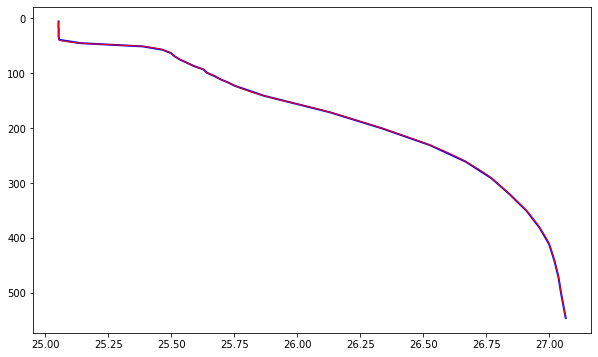

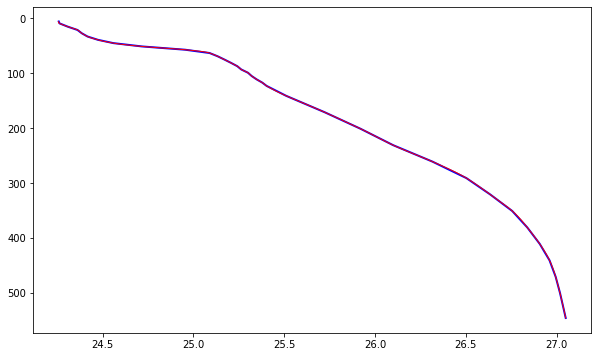

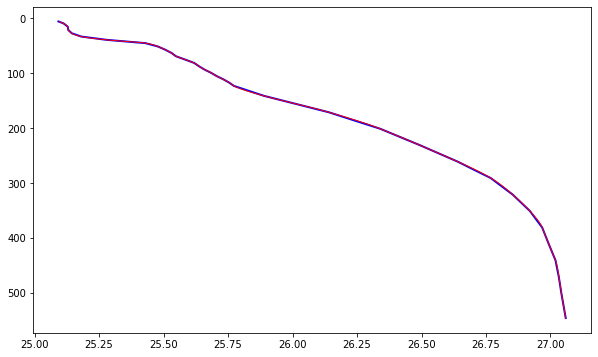

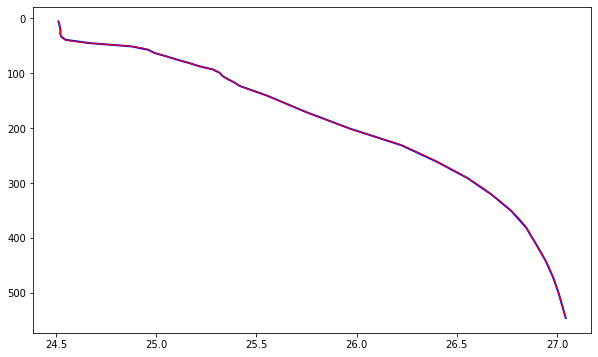

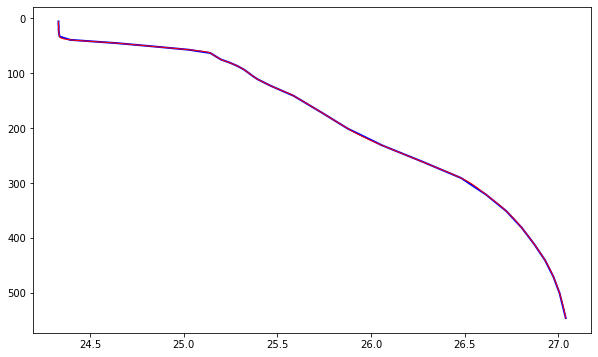

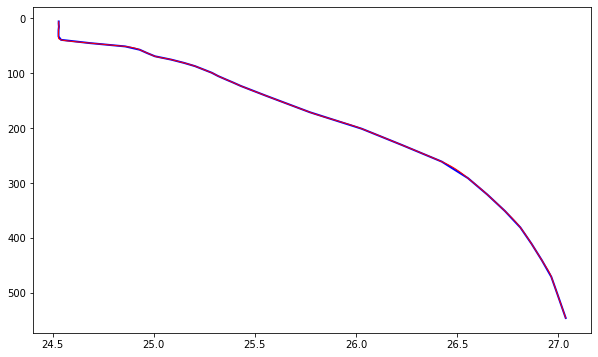

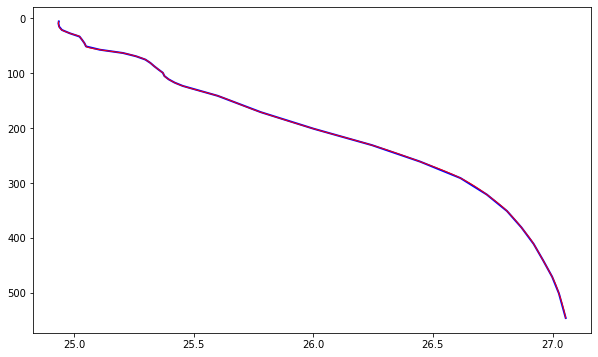

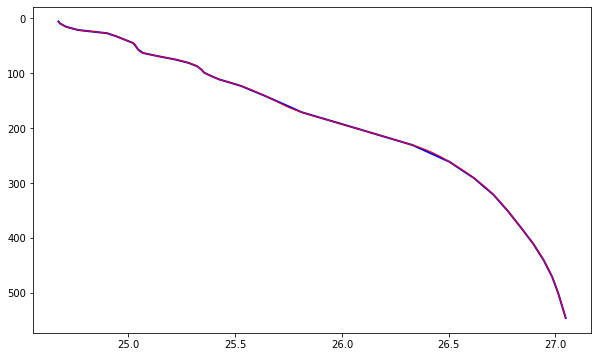

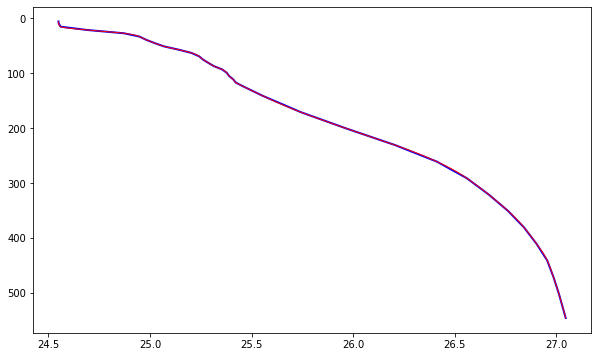

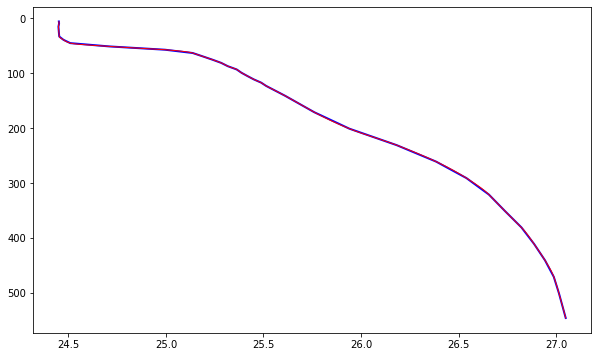

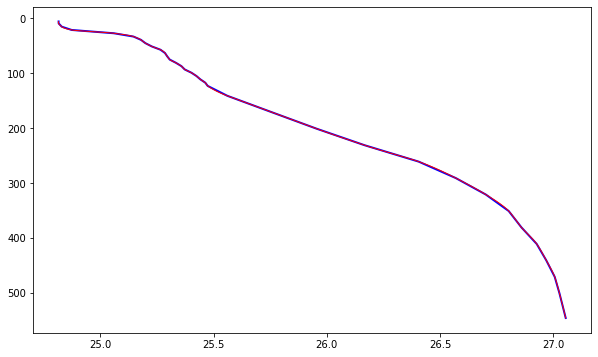

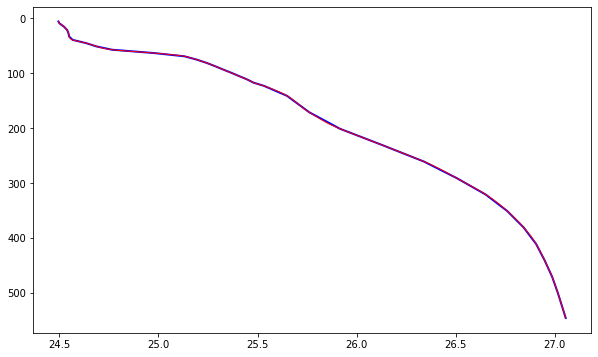

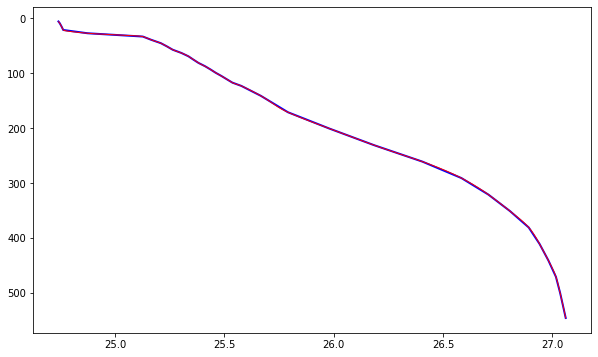

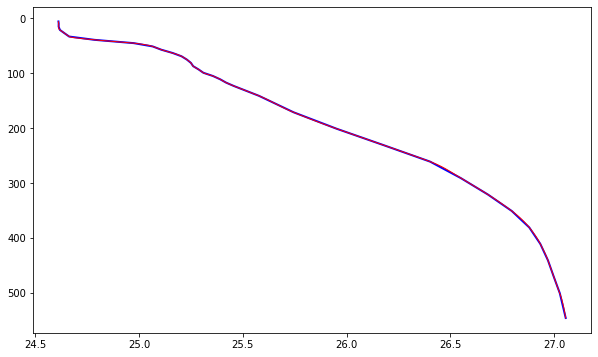

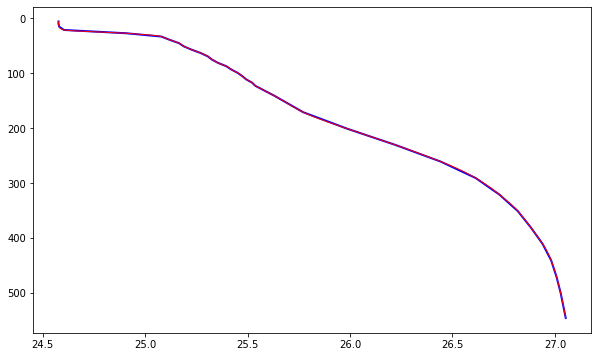

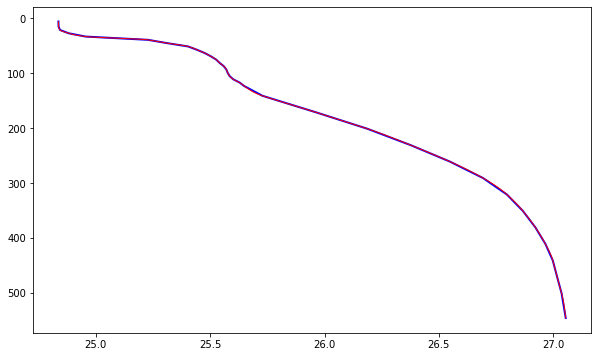

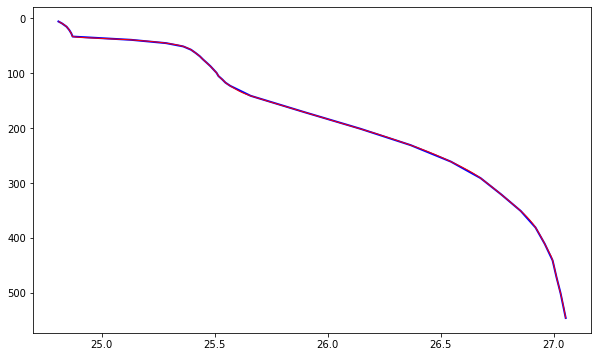

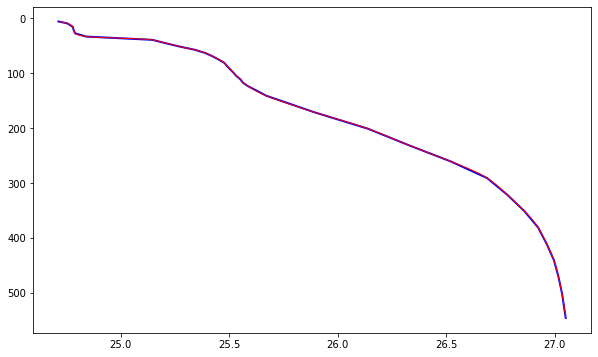

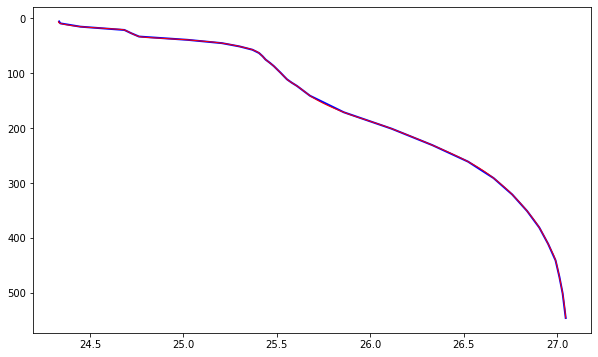

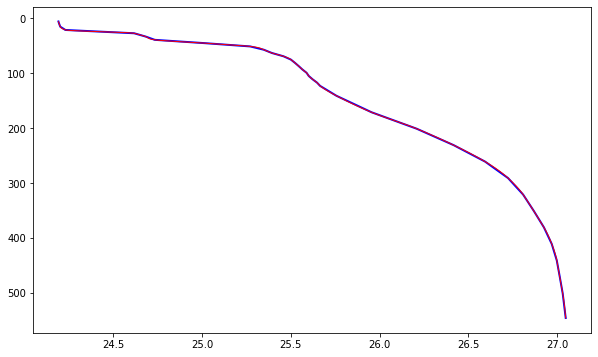

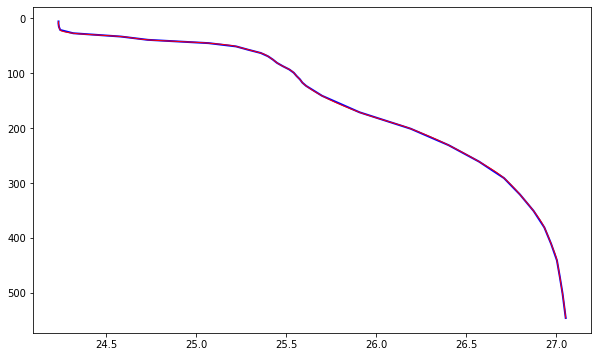

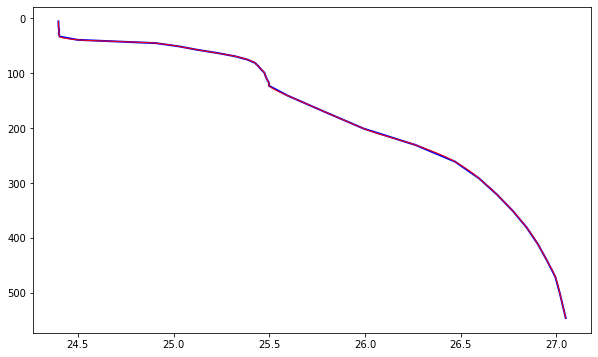

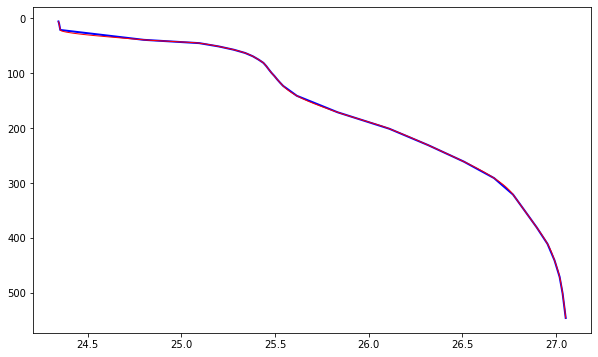

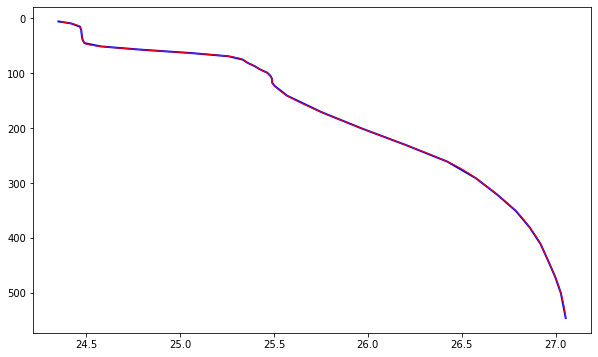

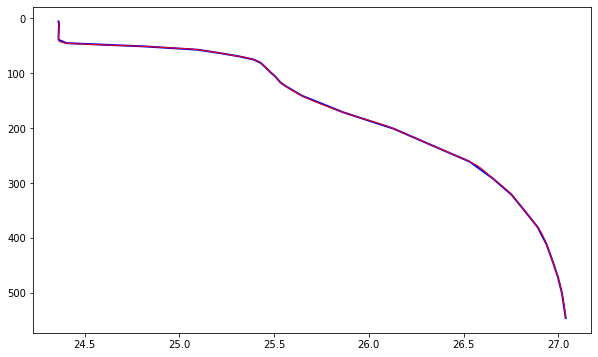

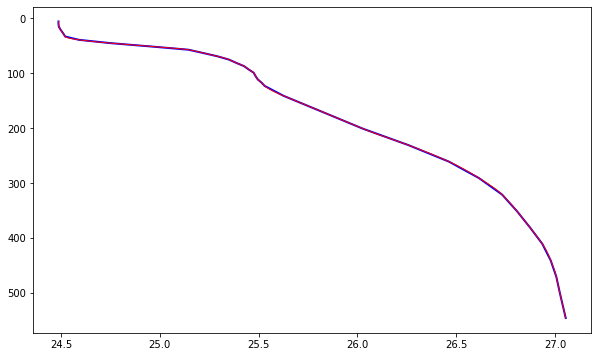

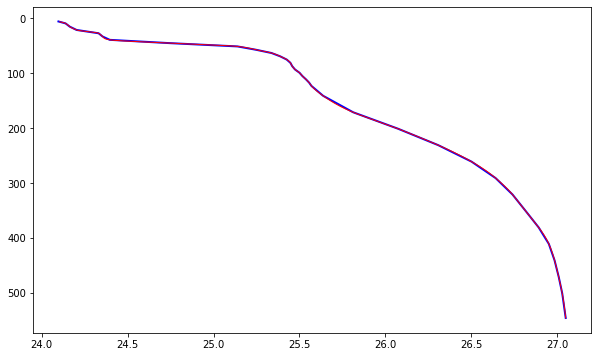

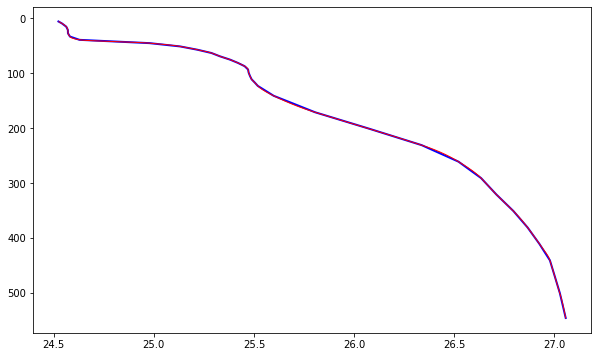

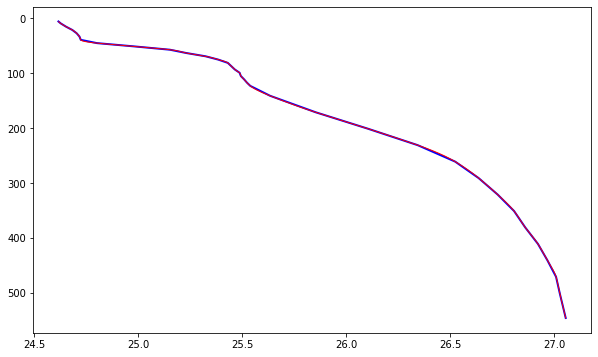

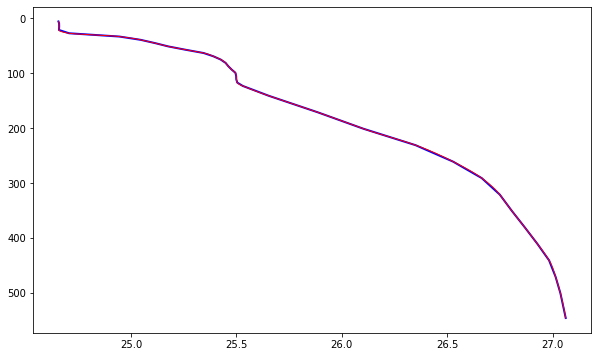

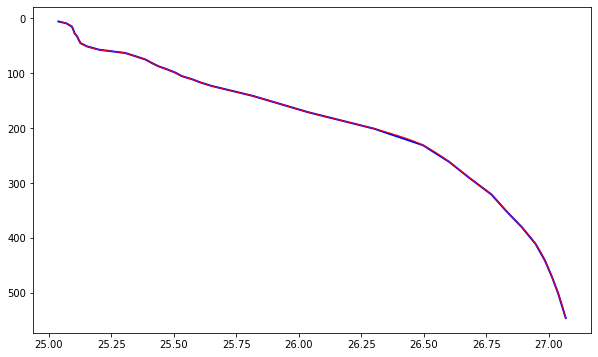

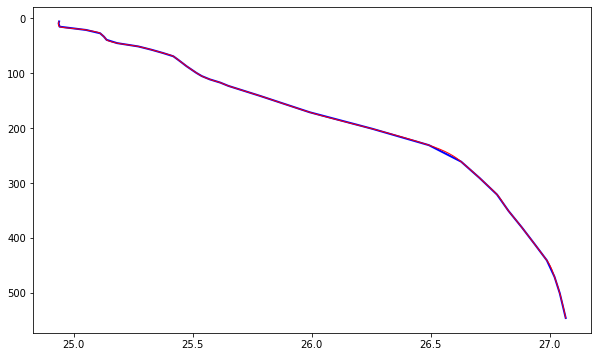

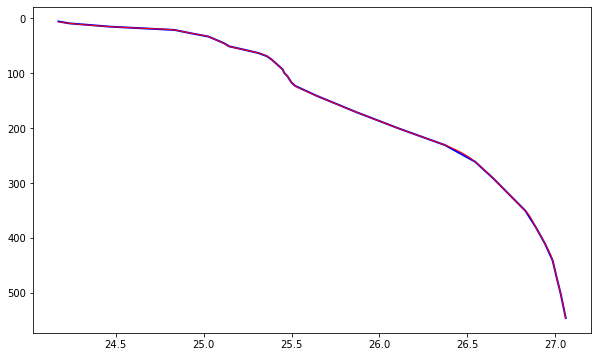

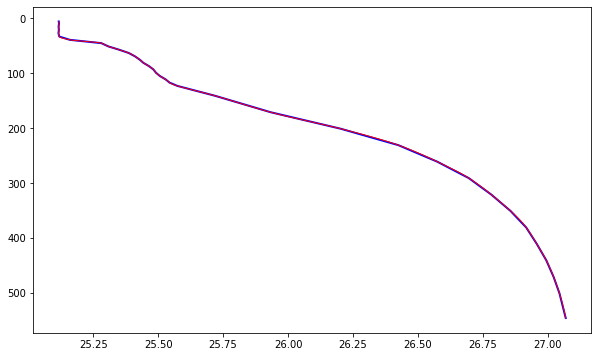

In [ ]:
import scipy.interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import Akima1DInterpolator
import math
import warnings
from itertools import repeat
warnings.filterwarnings("ignore") # Ignorar warnings
enero= lista_dfs[0]
############################################################################################################33
ids= list(enero.Id.unique()) # Ids unicos del dataframe
ciclos= list(enero.Ciclo.unique()) # ciclos unicos del dataframe
dfs= [] # Lista donde voy a almacener cada uno de los dataframes resultantes de la interpolacion
# Creacion de ciclo for para hacer interpolacion
for i in ids[0:1]: # Iterar solo el primer elemento (al final seria 0:len(ids))
  print('------------------------------------')
  print('Id :',i)
  #print('Ciclos disponibles:', ds_3D_m[ds_3D_m['Id']==i].Ciclo.unique()) # Solo para ver los ciclos del primer id
  ciclos=enero[enero['Id']==i].Ciclo.unique()
  for j in ciclos:
    print('Ciclo',j,'......................... Check')
    # Filtro del id y ciclo respectivo
    ds= enero[(enero['Id']==i) & (enero['Ciclo']==j)] # Variable local (se sobre escribe cada vez)
    # Hacer el subset entre 0 y 2000 dbar para que no haya problemas de consistencia
    ds= ds[(ds['Pres_Adj']>=0) &(ds['Pres_Adj']<=600)] # Importante para que todos los valores queden entre 0 y 2000 dbar
    #print(ds) # Si se quiere ver el dataframe original
    # Extraer presion, temperatura y salinidad
    pres= ds.Pres_Adj; D= ds.D; # Variables locales otra vez
    # Objetos interpoladores de Salinidad y Temperatura
    # Caso 1: Spline (Espero que de mejor)
    spline_D= Akima1DInterpolator(pres,D) # Mejor metodo que encontre
    # Ahora se hace la interpolacion entre el rango de valores de presion:
    min_pres= math.floor(np.min(pres));max_pres= math.ceil(np.max(pres))
    # Crear la secuencia de valores entre el minimo y maximo encontrado en el perfil para interpolar
    pres_new= np.arange(min_pres,max_pres+1,1)
    # Interpolar T y S con (Metodo: Splines)
    D_new=spline_D(pres_new)
    #################################################################
    # Nueva grafica
    plt.figure(figsize=(10,6))
    plt.plot(ds.D,ds.Pres_Adj,color='b',linewidth=2)
    plt.plot(D_new,pres_new,color='r',linewidth=1)
    plt.gca().invert_yaxis()
    #################################################################
     # Crear el dataframe para cada perfil
    df_ts=pd.DataFrame();
    # Agregar lat y lon, id y ciclo automatica
    lat_0=ds.Lat.reset_index(drop=True);lon_0=ds.Lon.reset_index(drop=True);id_0=ds.Id.reset_index(drop=True);ciclo_0=ds.Ciclo.reset_index(drop=True)  
    # Valores de 0 a 2000 dbar espaciados cada 1 dbar
    df_ts['Presion_interp']=np.arange(0,600+1,1)
    df_ts['Lon']= np.repeat(lon_0[0],601);df_ts['Lat']= np.repeat(lat_0[0],601)
    df_ts['Id']= np.repeat(id_0[0],601);df_ts['Ciclo']= np.repeat(ciclo_0[0],601);
    df_ts['D_interp']=np.nan; df_ts['D_interp'][min_pres:max_pres+1]= D_new;
    #print(df_ts)
    # Concatenar todos los dataframes en dfs
    dfs.append(df_ts)

## Creacion de funcion para generalizar

In [14]:
import scipy.interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import Akima1DInterpolator
import math
import warnings
from itertools import repeat
warnings.filterwarnings("ignore") # Ignorar warnings
def interpolador_capas(dataframe, max_depth, intervalo):
  '''
  dataframe= pandas dataframe con columnas Lon, Lat,ciclo, Pres_adj, Id, Variable
  max_depth= valor entero de profundidad maxima a interpolar
  intervalo= intervalo de profundidad en m para interpolacion
  '''
  # Enfocarme en estas profundidades
  lista_prof = list(np.arange(0,max_depth+1,intervalo)) # Intervalos de 5m para extraer capas
  ############################################################################################################33
  ds_3D_m=dataframe
  ids= list(ds_3D_m.Id.unique()) # Ids unicos del dataframe
  ciclos= list(ds_3D_m.Ciclo.unique()) # ciclos unicos del dataframe
  dfs= [] # Lista donde voy a almacener cada uno de los dataframes resultantes de la interpolacion
  for i in ids: 
    # Iterar solo el primer elemento (al final seria 0:len(ids))
    #print('------------------------------------')
    #print('Id :',i,'................... Check')
    #print('Ciclos disponibles:', ds_3D_m[ds_3D_m['Id']==i].Ciclo.unique()) # Solo para ver los ciclos del primer id
    ciclos=ds_3D_m[ds_3D_m['Id']==i].Ciclo.unique()
    for j in ciclos:
      #print('Ciclo',j,'......................... Check')
      # Filtro del id y ciclo respectivo
      ds= ds_3D_m[(ds_3D_m['Id']==i) & (ds_3D_m['Ciclo']==j)] # Variable local (se sobre escribe cada vez)
      # Hacer el subset entre 0 y 2000 dbar para que no haya problemas de consistencia
      ds= ds[(ds['Pres_Adj']>=0) &(ds['Pres_Adj']<=max_depth)] # Importante para que todos los valores queden entre 0 y 2000 dbar
      # Extraer presion, temperatura y salinidad
      pres= ds.Pres_Adj;D= ds.D;T=ds.Temp_Adj;S=ds.Sal_Adj # Variables locales otra vez
      # Objetos interpoladores de Salinidad y Temperatura
      # Caso 1: Spline (Espero que de mejor)
      try:
        spline_D= Akima1DInterpolator(pres,D) # Mejor metodo que encontre
        spline_T= Akima1DInterpolator(pres,T) # Mejor metodo que encontre
        spline_S= Akima1DInterpolator(pres,S) # Mejor metodo que encontre
        # Ahora se hace la interpolacion entre el rango de valores de presion:
        min_pres= math.floor(np.min(pres));max_pres= math.ceil(np.max(pres))
        # Crear la secuencia de valores entre el minimo y maximo encontrado en el perfil para interpolar
        pres_new= np.arange(min_pres,max_pres+1,1)
        D_new=spline_D(pres_new)# Interpolar T y S con (Metodo: Splines)
        T_new=spline_T(pres_new)# Interpolar T y S con (Metodo: Splines)
        S_new=spline_S(pres_new)# Interpolar T y S con (Metodo: Splines)
        df_ts=pd.DataFrame();# Crear el dataframe para cada perfil
        # Agregar lat y lon, id y ciclo automatica
        lat_0=ds.Lat.reset_index(drop=True);lon_0=ds.Lon.reset_index(drop=True);id_0=ds.Id.reset_index(drop=True);ciclo_0=ds.Ciclo.reset_index(drop=True)  
        df_ts['Presion_interp']=np.arange(0,max_depth+1,1)
        df_ts['Lon']= np.repeat(lon_0[0],max_depth+1);df_ts['Lat']= np.repeat(lat_0[0],max_depth+1)
        df_ts['Id']= np.repeat(id_0[0],max_depth+1);df_ts['Ciclo']= np.repeat(ciclo_0[0],max_depth+1);
        df_ts['D_interp']=np.nan;df_ts['D_interp'][min_pres:max_pres+1]= D_new;
        df_ts['T_interp']=np.nan;df_ts['T_interp'][min_pres:max_pres+1]= T_new;
        df_ts['S_interp']=np.nan;df_ts['S_interp'][min_pres:max_pres+1]= S_new;
        # Hacer el subset a las profundidades deseadas
        df_ts= df_ts[df_ts['Presion_interp'].isin(lista_prof)]
        dfs.append(df_ts)# Concatenar todos los dataframes en dfs
      except:
        #print('Intento fallido en Id:',i, 'Ciclo',j)
        pass
  # Interpolar para llenar la capa superficial
  dfs_final=[]
  for i in dfs:
    try:
      data_f= i.interpolate(method='spline', order=1,limit_direction='backward')
      dfs_final.append(data_f)# Agregar los dataframes
    except:
      dfs_final.append(i)
  print('Tamaño de los dataframes generados :',len(dfs_final))
  df_final= pd.concat(dfs_final)
  # Agrupar por cada Lat, Lon y Presion sacando la media que no tiene en cuenta los nan
  df_final=df_final[['Presion_interp','Lon','Lat','D_interp','T_interp','S_interp']].groupby(by=['Lon','Lat','Presion_interp']).mean().reset_index()
  print(df_final.shape)
  return df_final

## Validacion-DJF

In [15]:
DJF= interpolador_capas(dataframe= lista_dfs[0], max_depth= 600, intervalo=1)
DJF

Tamaño de los dataframes generados : 6759
(4062159, 6)


Lon     Lat  Presion_interp   D_interp   T_interp   S_interp
0       -24.994  31.964               0  26.302166  19.119570  36.610812
1       -24.994  31.964               1  26.304013  19.104146  36.608678
2       -24.994  31.964               2  26.305860  19.088722  36.606544
3       -24.994  31.964               3  26.307708  19.073298  36.604410
4       -24.994  31.964               4  26.309555  19.057873  36.602276
...         ...     ...             ...        ...        ...        ...
4062154  -5.010  44.573             596        NaN        NaN        NaN
4062155  -5.010  44.573             597        NaN        NaN        NaN
4062156  -5.010  44.573             598        NaN        NaN        NaN
4062157  -5.010  44.573             599        NaN        NaN        NaN
4062158  -5.010  44.573             600        NaN        NaN        NaN

[4062159 rows x 6 columns]

In [16]:
import scipy
from scipy.interpolate import griddata
ds_final= DJF #pasar los resultados del dataframe anteriores
# Lista para ir guardando cada matrix latxlon
datos_jan_D = []
datos_jan_T = []
datos_jan_S = []
for i in ds_final.Presion_interp.unique()[:-1]: # voy de 5m en adelante
  capa_x=ds_final[ds_final['Presion_interp']==i]
  # Grilla generica
  gridx = np.arange(-25+0.5,-5+0.5,1)# np.arange(-85,-70+1,1)
  gridy = np.arange(15+0.5, 45+0.5,1)#np.arange(-45, -15+1,1)
  grid_x, grid_y =scipy.meshgrid(gridx,gridy)
  points =np.array(capa_x[['Lon','Lat']])
  values_D=np.array(capa_x['D_interp'])
  values_T=np.array(capa_x['T_interp'])
  values_S=np.array(capa_x['S_interp'])
  # Interpoladores
  grid_z0_D=griddata(points,values_D, (grid_x,grid_y),method='linear')
  grid_z0_T=griddata(points,values_T, (grid_x,grid_y),method='linear')
  grid_z0_S=griddata(points,values_S, (grid_x,grid_y),method='linear')
  # Rotacion en el eje y Sur-Norte
  grid_z0_1_D=np.flip(grid_z0_D, axis=0)
  grid_z0_1_T=np.flip(grid_z0_T, axis=0)
  grid_z0_1_S=np.flip(grid_z0_S, axis=0)
  #print(grid_z0_1.shape)# Esto no es necesario despues
  datos_jan_D.append(grid_z0_1_D);datos_jan_T.append(grid_z0_1_T);datos_jan_S.append(grid_z0_1_S)
datos_D = np.stack(datos_jan_D);datos_T = np.stack(datos_jan_T);datos_S = np.stack(datos_jan_S)

In [17]:
print(datos_D.shape,datos_T.shape,datos_S.shape)

(600, 30, 20) (600, 30, 20) (600, 30, 20)


In [18]:
# Modelo data
T_DJF=np.mean(reanal.where(((reanal.month==1)|(reanal.month==2)|(reanal.month==12)), drop=True).CT.values,axis=0)
S_DJF=np.mean(reanal.where(((reanal.month==1)|(reanal.month==2)|(reanal.month==12)), drop=True).SA.values,axis=0)
D_DJF=np.mean(reanal.where(((reanal.month==1)|(reanal.month==2)|(reanal.month==12)), drop=True).D.values,axis=0)
print(T_DJF.shape, S_DJF.shape, D_DJF.shape)

(40, 121, 81) (40, 121, 81) (40, 121, 81)


In [19]:
# Interpolar a todas las capas para la misma grilla
x1= np.arange(-25+0.5, -5+0.5,1)
y1= list(np.arange(15+0.5, 45+0.5,1));y1=y1[::-1];y1= np.array(y1)
X_t, Y_t= np.meshgrid(x1,y1)
dat_D = []
dat_T = []
dat_S = []
for i in range(T_DJF.shape[0]):
  T_X=basemap.interp(datain=np.flipud(T_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  D_X=basemap.interp(datain=np.flipud(D_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  S_X=basemap.interp(datain=np.flipud(S_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  dat_D.append(D_X);dat_T.append(T_X);dat_S.append(S_X)
M_D = np.stack(dat_D);M_T = np.stack(dat_T);M_S = np.stack(dat_S)
print(M_D.shape, M_T.shape, M_S.shape)

(40, 30, 20) (40, 30, 20) (40, 30, 20)


<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -24.5 -23.5 -22.5 -21.5 -20.5 ... -8.5 -7.5 -6.5 -5.5
  * lat      (lat) float64 15.5 16.5 17.5 18.5 19.5 ... 40.5 41.5 42.5 43.5 44.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 23.76 23.65 23.63 ... 11.02 11.02 11.0
    S        (depth, lat, lon) float64 36.36 36.27 36.11 ... 35.77 35.76 35.76
    D        (depth, lat, lon) float64 24.64 24.61 24.49 ... 27.29 27.28 27.28

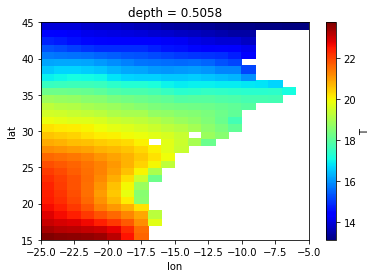

In [20]:
M_final=dt=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],M_T),"S":(['depth',"lat","lon"],M_S),"D":(['depth',"lat","lon"],M_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.arange(15+0.5, 45+0.5,1), 
                        "depth": reanal.depth.values})
M_final.T.sel(depth=M_final.depth.values[0]).plot(cmap='jet')
M_final

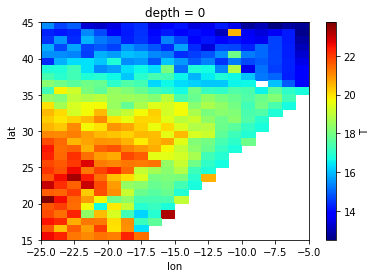

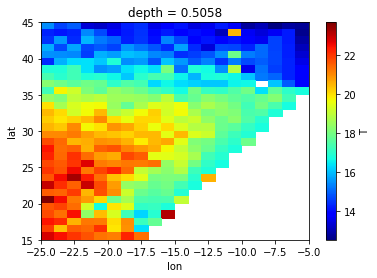

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -24.5 -23.5 -22.5 -21.5 -20.5 ... -8.5 -7.5 -6.5 -5.5
  * lat      (lat) float64 44.5 43.5 42.5 41.5 40.5 ... 19.5 18.5 17.5 16.5 15.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 15.49 14.63 14.94 13.37 ... nan nan nan
    S        (depth, lat, lon) float64 35.95 35.92 35.88 35.79 ... nan nan nan
    D        (depth, lat, lon) float64 26.66 26.83 26.73 26.98 ... nan nan nan

In [21]:
A_no_interp=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.array(list(np.arange(15+0.5, 45+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)})
A_final=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.array(list(np.arange(15+0.5, 45+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)}).interp(depth=reanal.depth.values)
A_no_interp.T.sel(depth=A_no_interp.depth.values[0]).plot(cmap='jet')
plt.show()
A_final.T.sel(depth=A_final.depth.values[0]).plot(cmap='jet')
plt.show()
A_final

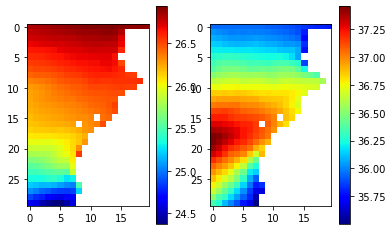

In [ ]:
plt.subplot(121)
plt.imshow(np.flipud(M_D[0,:,:]),cmap='jet')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.flipud(M_S[0,:,:]),cmap='jet')
plt.colorbar()
#plt.subplot(133)
#plt.imshow(np.flipud(M_S[0,:,:]),cmap='jet')
#plt.colorbar()

### Graficos transectas pruebas

In [ ]:
X_t[0]

array([-129.5, -128.5, -127.5, -126.5, -125.5, -124.5, -123.5, -122.5,
       -121.5, -120.5, -119.5, -118.5, -117.5, -116.5, -115.5, -114.5,
       -113.5, -112.5, -111.5, -110.5])

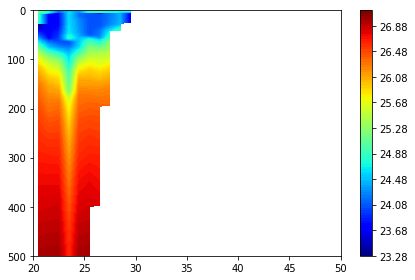

In [ ]:
prof= np.arange(0,600,1) # profundidades 
xts1=X_t[0,:]
yt1=Y_t[:,0]
tran_lat1=datos_D[:,:,-5]# 0:-84.5 , 1: -83.5 ,......
plt.contourf(yt1,prof, tran_lat1,cmap='jet',levels=100)
#plt.contour(yt1,prof, tran_lat1,cmap='jet',levels=100)
plt.colorbar()
plt.ylim([0,500])
plt.xlim([20,50])
plt.tight_layout()
plt.margins(x=0)
plt.gca().invert_yaxis()

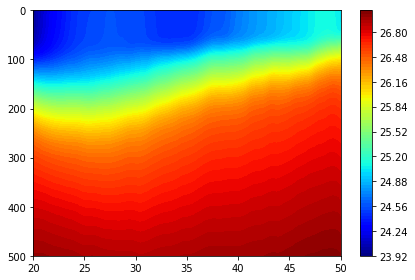

In [ ]:
D_M=reanal.D.sel(lon=-129.5).where((reanal.month==1)|(reanal.month==2)|(reanal.month==12), drop=True).mean('month').values
prof_M= reanal.depth.values # profundidades 
plt.contourf(reanal.lat.values,prof_M,D_M,cmap='jet',levels=100)
#plt.contour(yt1,prof, tran_lat1,cmap='jet',levels=100)
plt.colorbar()
plt.ylim([0,500])
plt.xlim([20,50])
plt.tight_layout()
plt.margins(x=0)
plt.gca().invert_yaxis()

In [ ]:
Y_t[:,0]

array([49.5, 48.5, 47.5, 46.5, 45.5, 44.5, 43.5, 42.5, 41.5, 40.5, 39.5,
       38.5, 37.5, 36.5, 35.5, 34.5, 33.5, 32.5, 31.5, 30.5, 29.5, 28.5,
       27.5, 26.5, 25.5, 24.5, 23.5, 22.5, 21.5, 20.5])

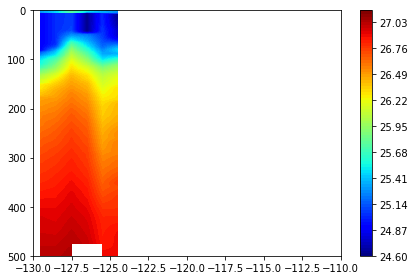

In [ ]:
tran_lat2=datos_D[:,5,:]# 0:-15.5 , 1: -16.5 ,......
plt.contourf(xts1,prof, tran_lat2,cmap='jet',levels=100)
#plt.contour(yt1,prof, tran_lat1,cmap='jet',levels=100)
plt.colorbar()
plt.ylim([0,500])
plt.xlim([-130,-110])
plt.tight_layout()
plt.margins(x=0)
plt.gca().invert_yaxis()

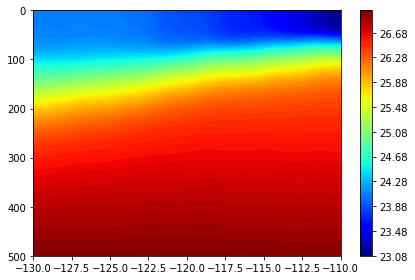

In [ ]:
D_M=reanal.D.sel(lat=20.5).where((reanal.month==1)|(reanal.month==2)|(reanal.month==12), drop=True).mean('month').values
prof_M= reanal.depth.values # profundidades 
plt.contourf(reanal.lon.values,prof_M,D_M,cmap='jet',levels=100)
#plt.contour(yt1,prof, tran_lat1,cmap='jet',levels=100)
plt.colorbar()
plt.ylim([0,500])
plt.xlim([-130,-110])
plt.tight_layout()
plt.margins(x=0)
plt.gca().invert_yaxis()

### Graficas finales transectas

### Latitudinales

In [24]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lon_Y= [-23.5,-17.5,-11.5,-6.5]
for i in range(4):
  tran_lat_d=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_s=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_t=A_final.sel(lon=lon_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lon=lon_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lon=lon_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lon=lon_Y[i]).T.values
  tran_lat_dx=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_sx=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_tx=A_final.sel(lon=lon_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(np.flip(tran_lat_M_d,axis=1));lista_ARGOX_LAT_D.append(np.flip((M_final.sel(lon=lon_Y[i]).D-A_final.sel(lon=lon_Y[i]).D).values,axis=1))
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(np.flip(tran_lat_M_s,axis=1));lista_ARGOX_LAT_S.append(np.flip((M_final.sel(lon=lon_Y[i]).S-A_final.sel(lon=lon_Y[i]).S).values,axis=1))
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(np.flip(tran_lat_M_t,axis=1));lista_ARGOX_LAT_T.append(np.flip((M_final.sel(lon=lon_Y[i]).T-A_final.sel(lon=lon_Y[i]).T).values,axis=1))
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

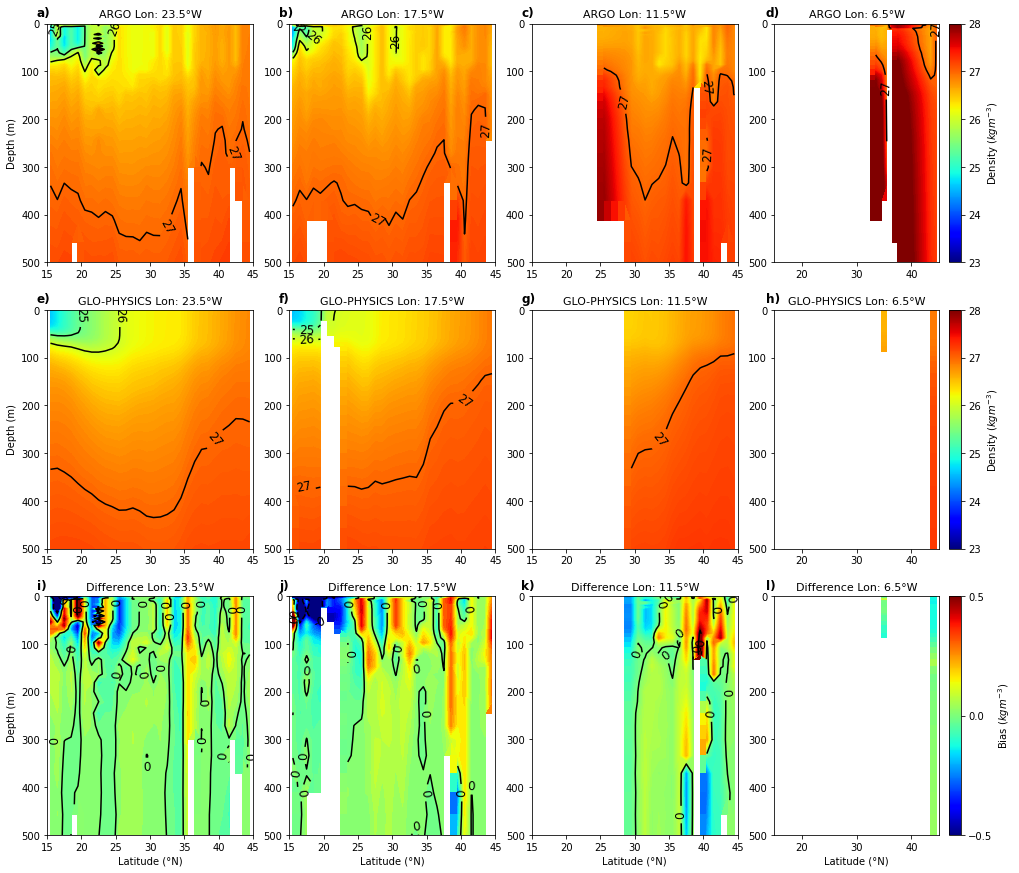

In [27]:
import string
vmins= [23]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [28]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[-0.5,0,0.5]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

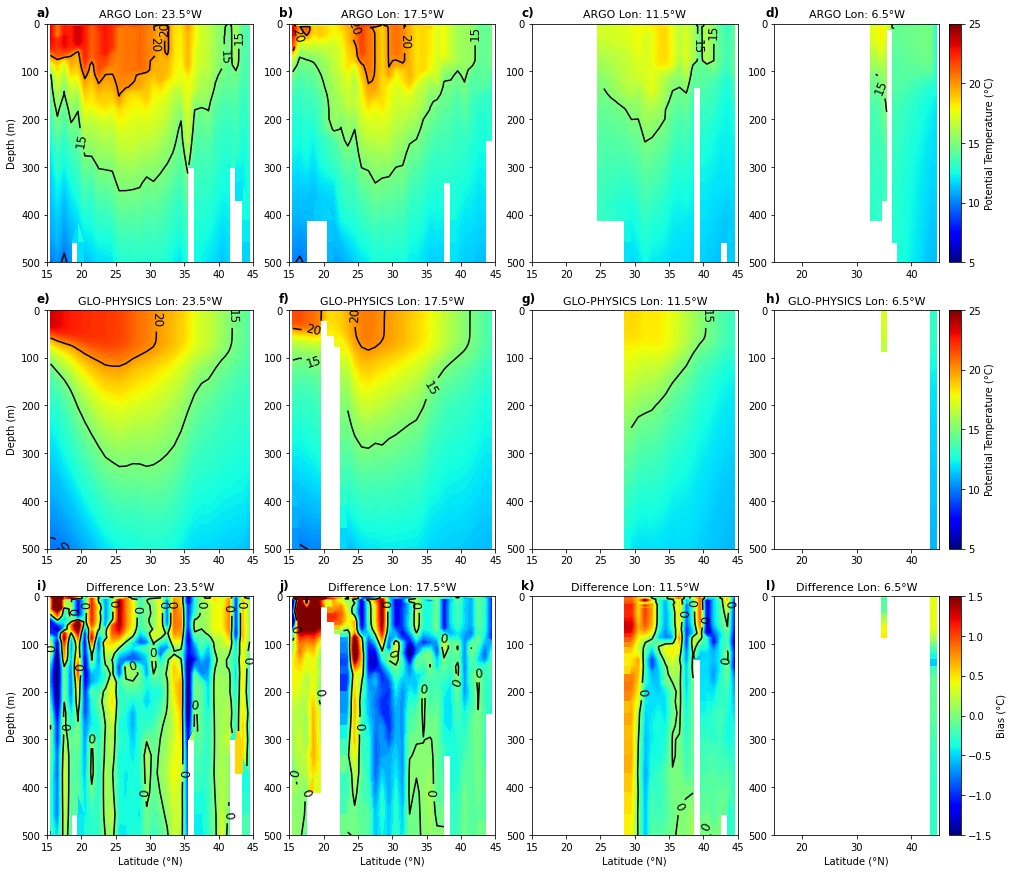

In [28]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

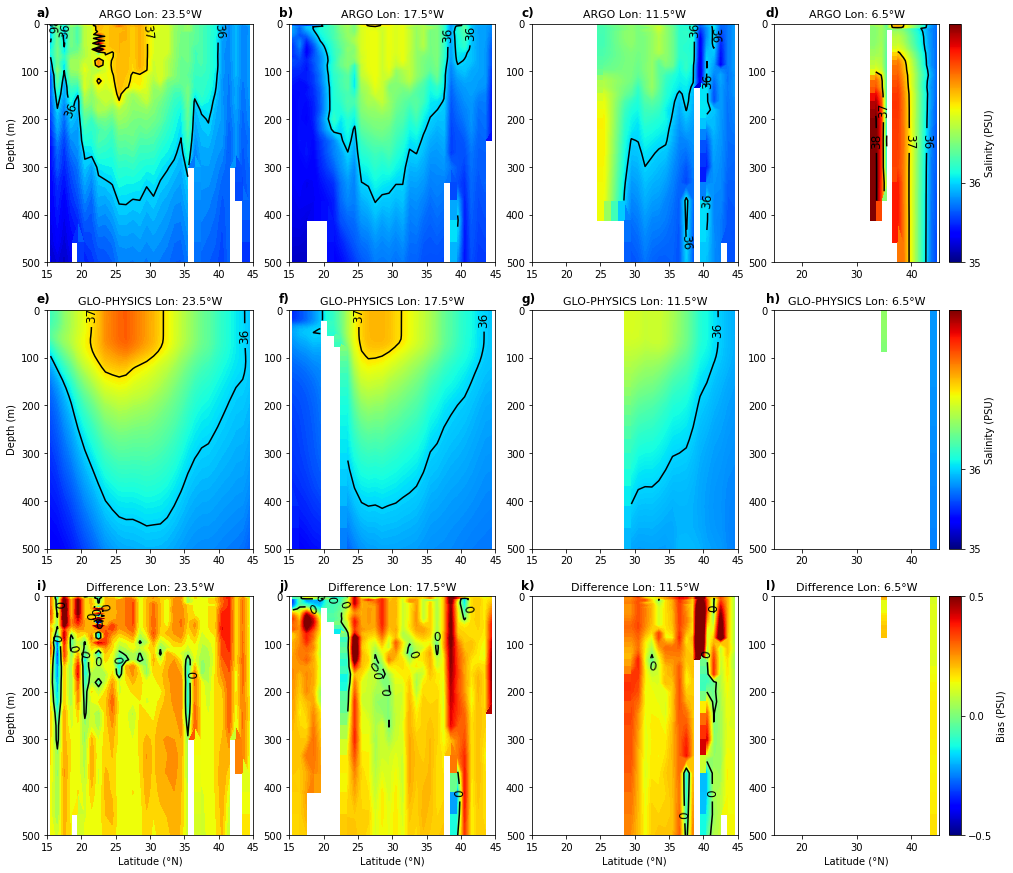

In [30]:
import string
vmins= [35]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [38]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[35,36,37,38]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Longitudinales

In [32]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lat_Y= [43.5,35.5,27.5,19.5]
for i in range(4):
  tran_lat_d=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_s=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_t=A_final.sel(lat=lat_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lat=lat_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lat=lat_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lat=lat_Y[i]).T.values
  tran_lat_dx=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_sx=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_tx=A_final.sel(lat=lat_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(tran_lat_M_d);lista_ARGOX_LAT_D.append((M_final.sel(lat=lat_Y[i]).D-A_final.sel(lat=lat_Y[i]).D).values)
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(tran_lat_M_s);lista_ARGOX_LAT_S.append((M_final.sel(lat=lat_Y[i]).S-A_final.sel(lat=lat_Y[i]).S).values)
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(tran_lat_M_t);lista_ARGOX_LAT_T.append((M_final.sel(lat=lat_Y[i]).T-A_final.sel(lat=lat_Y[i]).T).values)
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_D[0][lista_final_D[0]>27.10728928778205]= 27.10728928778205-0.2
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_S[0][lista_final_S[0]>36]= 36-0.4
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

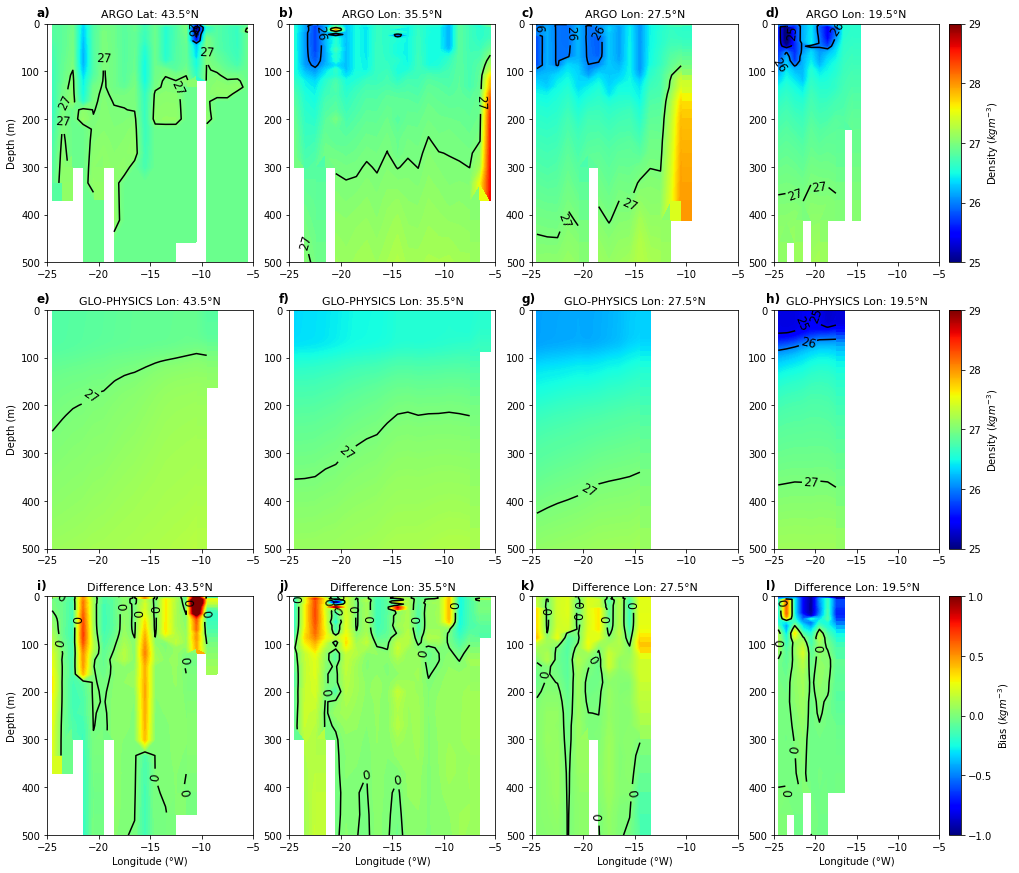

In [34]:
import string
vmins= [25]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [29]*8 + [1]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([25,26,27,28,29]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

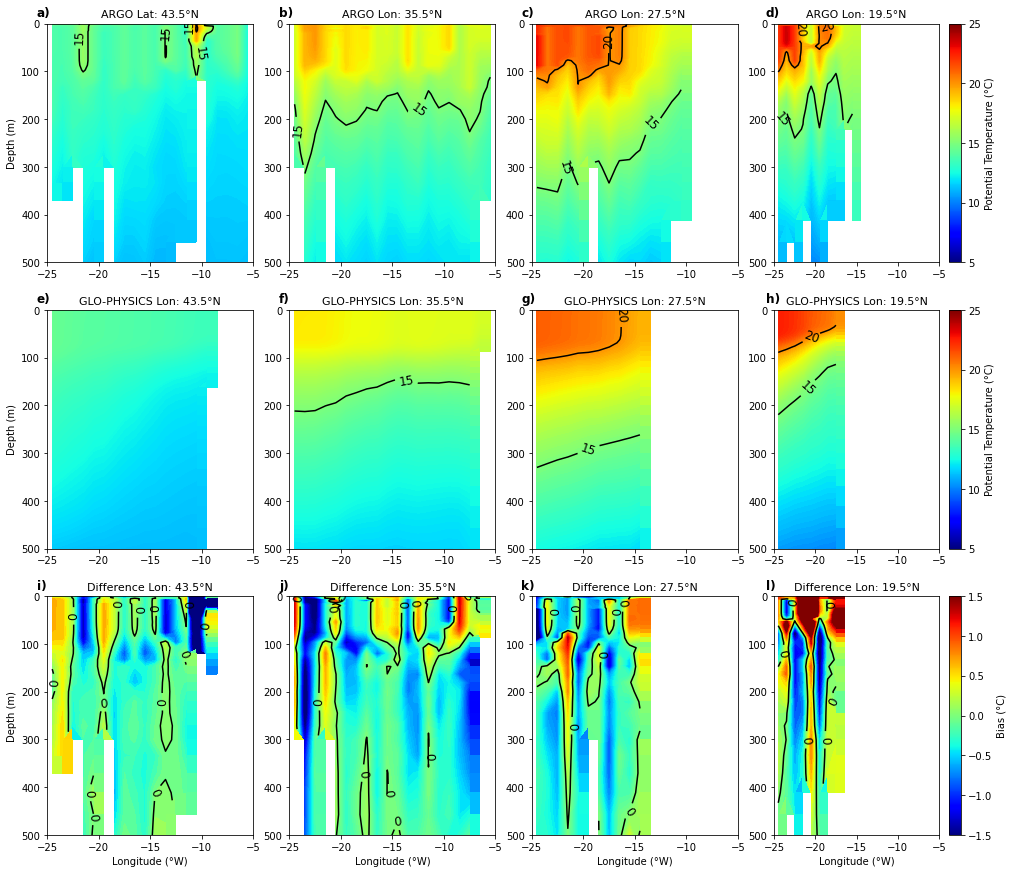

In [35]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

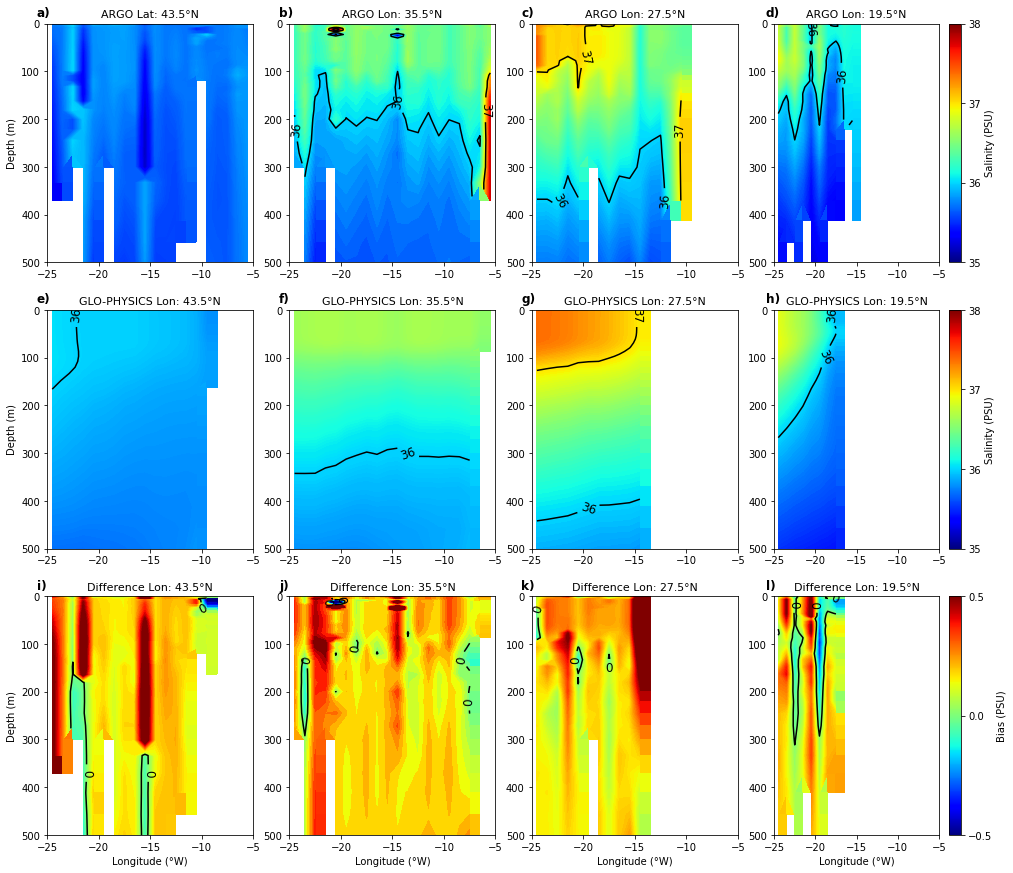

In [36]:
import string
vmins= [35]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [38]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[35,36,37,38]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([35,36,37,38]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Diagramas de Taylor

In [37]:
STD_D=[];CORRCOEF_D=[];RMSE_D=[]
STD_S=[];CORRCOEF_S=[];RMSE_S=[]
STD_T=[];CORRCOEF_T=[];RMSE_T=[]
for i in range(40):
  ###### DEN ######
  modelo= np.flipud(M_final.D.values[i,:,:]).flatten()
  satelite= A_final.D.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_D.append(np.ma.std(P.ravel()))
  CORRCOEF_D.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_D.append(np.sqrt(np.mean((P-A)**2)))
  ###### SAL ######
  modelo= np.flipud(M_final.S.values[i,:,:]).flatten()
  satelite= A_final.S.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_S.append(np.ma.std(P.ravel()))
  CORRCOEF_S.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_S.append(np.sqrt(np.mean((P-A)**2)))
  ###### TEMP ######
  modelo= np.flipud(M_final.T.values[i,:,:]).flatten()
  satelite= A_final.T.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_T.append(np.ma.std(P.ravel()))
  CORRCOEF_T.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_T.append(np.sqrt(np.mean((P-A)**2)))

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

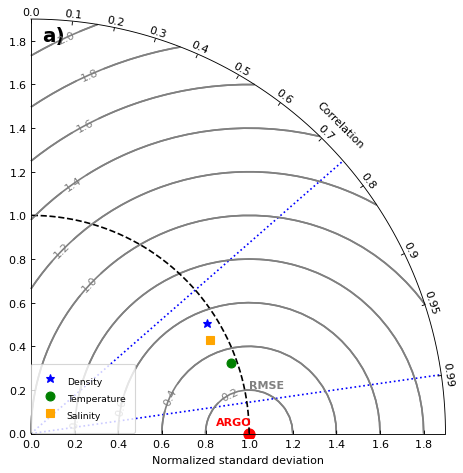

In [38]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0., 1.9), label='ARGO')
pp=[]
ttt=TayDia.add_sample(np.mean(STD_D), np.mean(CORRCOEF_D)+0.05, marker="*", linestyle='None', color='blue', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_T), np.mean(CORRCOEF_T), marker="o", linestyle='None', color='green', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_S), np.mean(CORRCOEF_S), marker="s", linestyle='None', color='orange', ms=8);pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -1.25**2)],[0,1.25], color='blue',linestyle=':') # correlacion 0.75
plt.plot([0,NP.sqrt(1.9**2 -0.27**2)],[0,0.27], color='blue',linestyle=':') # correlacion 0.99
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, ['Density','Temperature','Salinity'],  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'ARGO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'a)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

## Validacion -MAM

In [39]:
MAM= interpolador_capas(dataframe= lista_dfs[1], max_depth= 600, intervalo=1)
MAM

Tamaño de los dataframes generados : 6987
(4199187, 6)


Lon     Lat  Presion_interp   D_interp   T_interp   S_interp
0       -24.996  38.283               0  26.737399  15.777608  36.136034
1       -24.996  38.283               1  26.738179  15.770361  36.135053
2       -24.996  38.283               2  26.738959  15.763113  36.134073
3       -24.996  38.283               3  26.739739  15.755866  36.133093
4       -24.996  38.283               4  26.740519  15.748618  36.132113
...         ...     ...             ...        ...        ...        ...
4199182  -5.031  44.750             596        NaN        NaN        NaN
4199183  -5.031  44.750             597        NaN        NaN        NaN
4199184  -5.031  44.750             598        NaN        NaN        NaN
4199185  -5.031  44.750             599        NaN        NaN        NaN
4199186  -5.031  44.750             600        NaN        NaN        NaN

[4199187 rows x 6 columns]

In [40]:
import scipy
from scipy.interpolate import griddata
ds_final= MAM #pasar los resultados del dataframe anteriores
# Lista para ir guardando cada matrix latxlon
datos_jan_D = []
datos_jan_T = []
datos_jan_S = []
for i in ds_final.Presion_interp.unique()[:-1]: # voy de 5m en adelante
  capa_x=ds_final[ds_final['Presion_interp']==i]
  # Grilla generica
  gridx = np.arange(-25+0.5,-5+0.5,1)# np.arange(-85,-70+1,1)
  gridy = np.arange(15+0.5, 45+0.5,1)#np.arange(-45, -15+1,1)
  grid_x, grid_y =scipy.meshgrid(gridx,gridy)
  points =np.array(capa_x[['Lon','Lat']])
  values_D=np.array(capa_x['D_interp'])
  values_T=np.array(capa_x['T_interp'])
  values_S=np.array(capa_x['S_interp'])
  # Interpoladores
  grid_z0_D=griddata(points,values_D, (grid_x,grid_y),method='linear')
  grid_z0_T=griddata(points,values_T, (grid_x,grid_y),method='linear')
  grid_z0_S=griddata(points,values_S, (grid_x,grid_y),method='linear')
  # Rotacion en el eje y Sur-Norte
  grid_z0_1_D=np.flip(grid_z0_D, axis=0)
  grid_z0_1_T=np.flip(grid_z0_T, axis=0)
  grid_z0_1_S=np.flip(grid_z0_S, axis=0)
  #print(grid_z0_1.shape)# Esto no es necesario despues
  datos_jan_D.append(grid_z0_1_D);datos_jan_T.append(grid_z0_1_T);datos_jan_S.append(grid_z0_1_S)
datos_D = np.stack(datos_jan_D);datos_T = np.stack(datos_jan_T);datos_S = np.stack(datos_jan_S)

In [41]:
print(datos_D.shape,datos_T.shape,datos_S.shape)

(600, 30, 20) (600, 30, 20) (600, 30, 20)


In [42]:
# Modelo data
T_DJF=np.mean(reanal.where(((reanal.month==3)|(reanal.month==4)|(reanal.month==5)), drop=True).CT.values,axis=0)
S_DJF=np.mean(reanal.where(((reanal.month==3)|(reanal.month==4)|(reanal.month==5)), drop=True).SA.values,axis=0)
D_DJF=np.mean(reanal.where(((reanal.month==3)|(reanal.month==4)|(reanal.month==5)), drop=True).D.values,axis=0)
print(T_DJF.shape, S_DJF.shape, D_DJF.shape)

(40, 121, 81) (40, 121, 81) (40, 121, 81)


In [43]:
# Interpolar a todas las capas para la misma grilla
x1= np.arange(-25+0.5, -5+0.5,1)
y1= list(np.arange(15+0.5, 45+0.5,1));y1=y1[::-1];y1= np.array(y1)
X_t, Y_t= np.meshgrid(x1,y1)
dat_D = []
dat_T = []
dat_S = []
for i in range(T_DJF.shape[0]):
  T_X=basemap.interp(datain=np.flipud(T_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  D_X=basemap.interp(datain=np.flipud(D_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  S_X=basemap.interp(datain=np.flipud(S_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  dat_D.append(D_X);dat_T.append(T_X);dat_S.append(S_X)
M_D = np.stack(dat_D);M_T = np.stack(dat_T);M_S = np.stack(dat_S)
print(M_D.shape, M_T.shape, M_S.shape)

(40, 30, 20) (40, 30, 20) (40, 30, 20)


<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -24.5 -23.5 -22.5 -21.5 -20.5 ... -8.5 -7.5 -6.5 -5.5
  * lat      (lat) float64 15.5 16.5 17.5 18.5 19.5 ... 40.5 41.5 42.5 43.5 44.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 23.22 23.0 22.72 ... 10.98 10.99 10.97
    S        (depth, lat, lon) float64 36.27 36.23 36.16 ... 35.77 35.76 35.76
    D        (depth, lat, lon) float64 24.74 24.77 24.8 ... 27.29 27.28 27.29

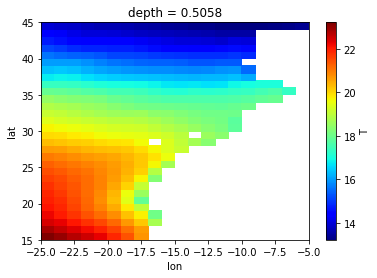

In [44]:
M_final=dt=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],M_T),"S":(['depth',"lat","lon"],M_S),"D":(['depth',"lat","lon"],M_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.arange(15+0.5, 45+0.5,1), 
                        "depth": reanal.depth.values})
M_final.T.sel(depth=M_final.depth.values[0]).plot(cmap='jet')
M_final

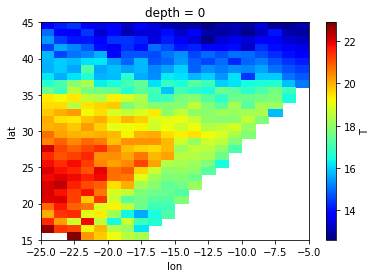

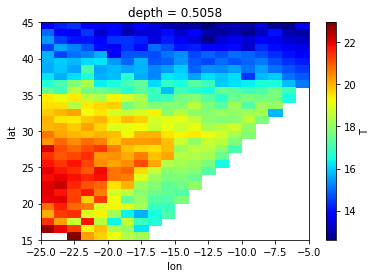

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -24.5 -23.5 -22.5 -21.5 -20.5 ... -8.5 -7.5 -6.5 -5.5
  * lat      (lat) float64 44.5 43.5 42.5 41.5 40.5 ... 19.5 18.5 17.5 16.5 15.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 13.77 14.15 14.4 13.72 ... nan nan nan
    S        (depth, lat, lon) float64 35.7 35.83 35.87 35.51 ... nan nan nan
    D        (depth, lat, lon) float64 26.83 26.87 26.84 26.69 ... nan nan nan

In [45]:
A_no_interp=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.array(list(np.arange(15+0.5, 45+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)})
A_final=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.array(list(np.arange(15+0.5, 45+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)}).interp(depth=reanal.depth.values)
A_no_interp.T.sel(depth=A_no_interp.depth.values[0]).plot(cmap='jet')
plt.show()
A_final.T.sel(depth=A_final.depth.values[0]).plot(cmap='jet')
plt.show()
A_final

### Graficas finales transectas

### Latitudinales

In [46]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lon_Y= [-23.5,-17.5,-11.5,-6.5]
for i in range(4):
  tran_lat_d=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_s=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_t=A_final.sel(lon=lon_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lon=lon_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lon=lon_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lon=lon_Y[i]).T.values
  tran_lat_dx=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_sx=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_tx=A_final.sel(lon=lon_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(np.flip(tran_lat_M_d,axis=1));lista_ARGOX_LAT_D.append(np.flip((M_final.sel(lon=lon_Y[i]).D-A_final.sel(lon=lon_Y[i]).D).values,axis=1))
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(np.flip(tran_lat_M_s,axis=1));lista_ARGOX_LAT_S.append(np.flip((M_final.sel(lon=lon_Y[i]).S-A_final.sel(lon=lon_Y[i]).S).values,axis=1))
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(np.flip(tran_lat_M_t,axis=1));lista_ARGOX_LAT_T.append(np.flip((M_final.sel(lon=lon_Y[i]).T-A_final.sel(lon=lon_Y[i]).T).values,axis=1))
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

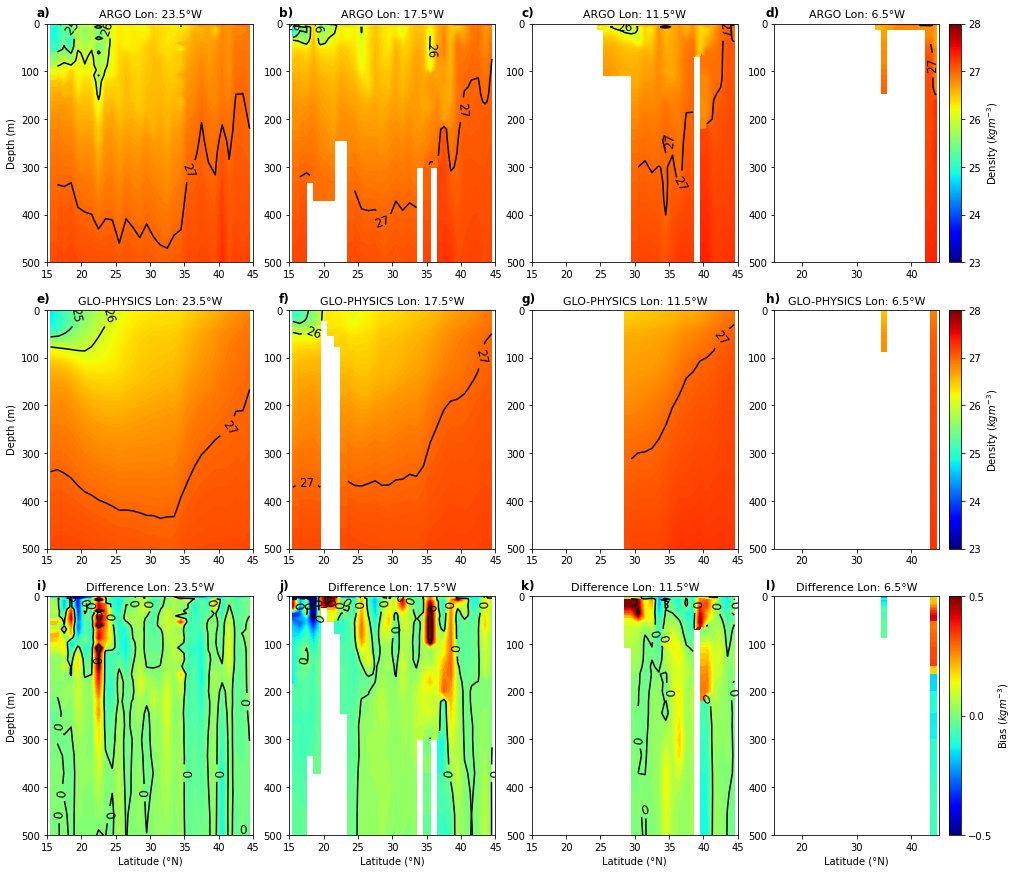

In [47]:
import string
vmins= [23]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [28]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[-0.5,0,0.5]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

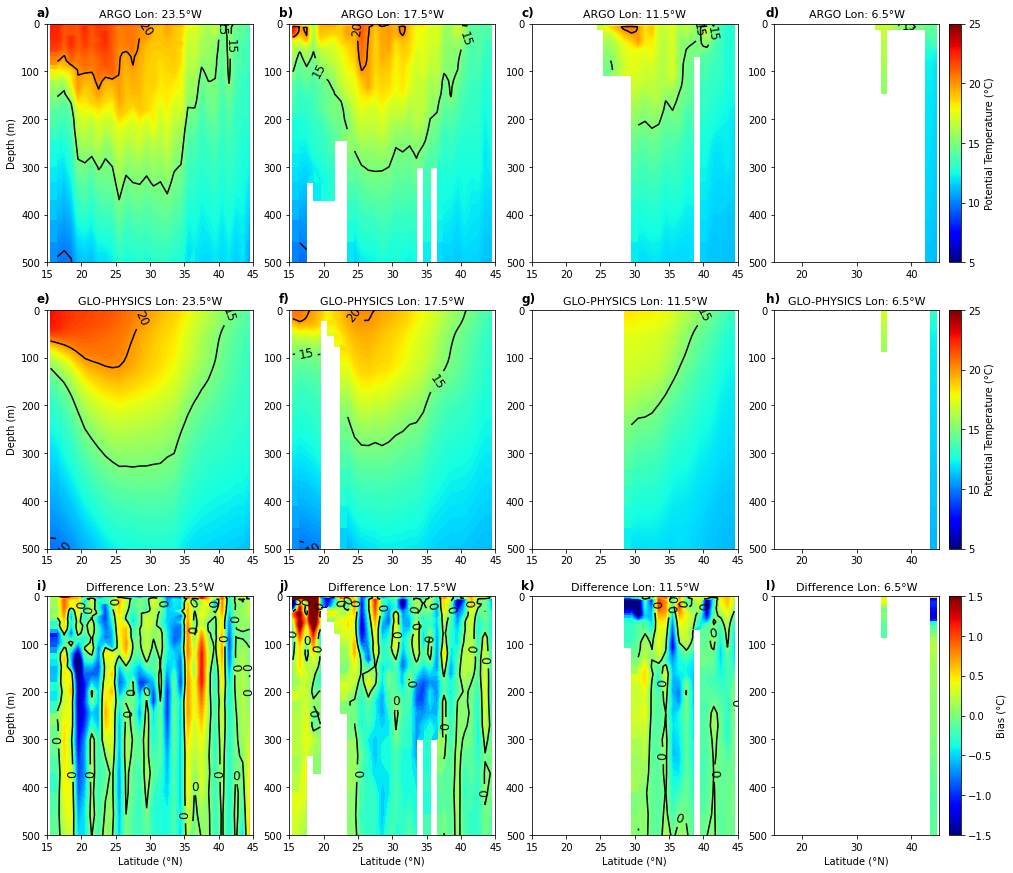

In [48]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

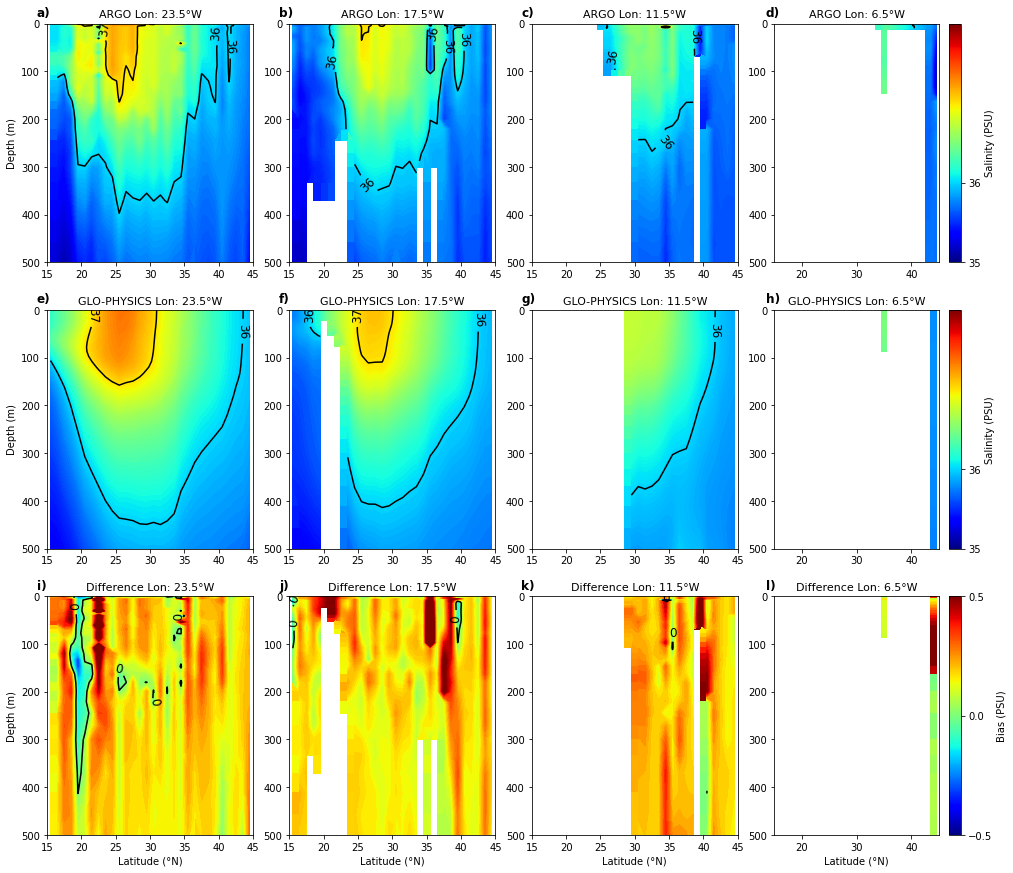

In [49]:
import string
vmins= [35]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [38]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[35,36,37,38]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Longitudinales

In [50]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lat_Y= [43.5,35.5,27.5,19.5]
for i in range(4):
  tran_lat_d=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_s=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_t=A_final.sel(lat=lat_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lat=lat_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lat=lat_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lat=lat_Y[i]).T.values
  tran_lat_dx=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_sx=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_tx=A_final.sel(lat=lat_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(tran_lat_M_d);lista_ARGOX_LAT_D.append((M_final.sel(lat=lat_Y[i]).D-A_final.sel(lat=lat_Y[i]).D).values)
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(tran_lat_M_s);lista_ARGOX_LAT_S.append((M_final.sel(lat=lat_Y[i]).S-A_final.sel(lat=lat_Y[i]).S).values)
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(tran_lat_M_t);lista_ARGOX_LAT_T.append((M_final.sel(lat=lat_Y[i]).T-A_final.sel(lat=lat_Y[i]).T).values)
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_D[0][lista_final_D[0]>27.10728928778205]= 27.10728928778205-0.2
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_S[0][lista_final_S[0]>36]= 36-0.4
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

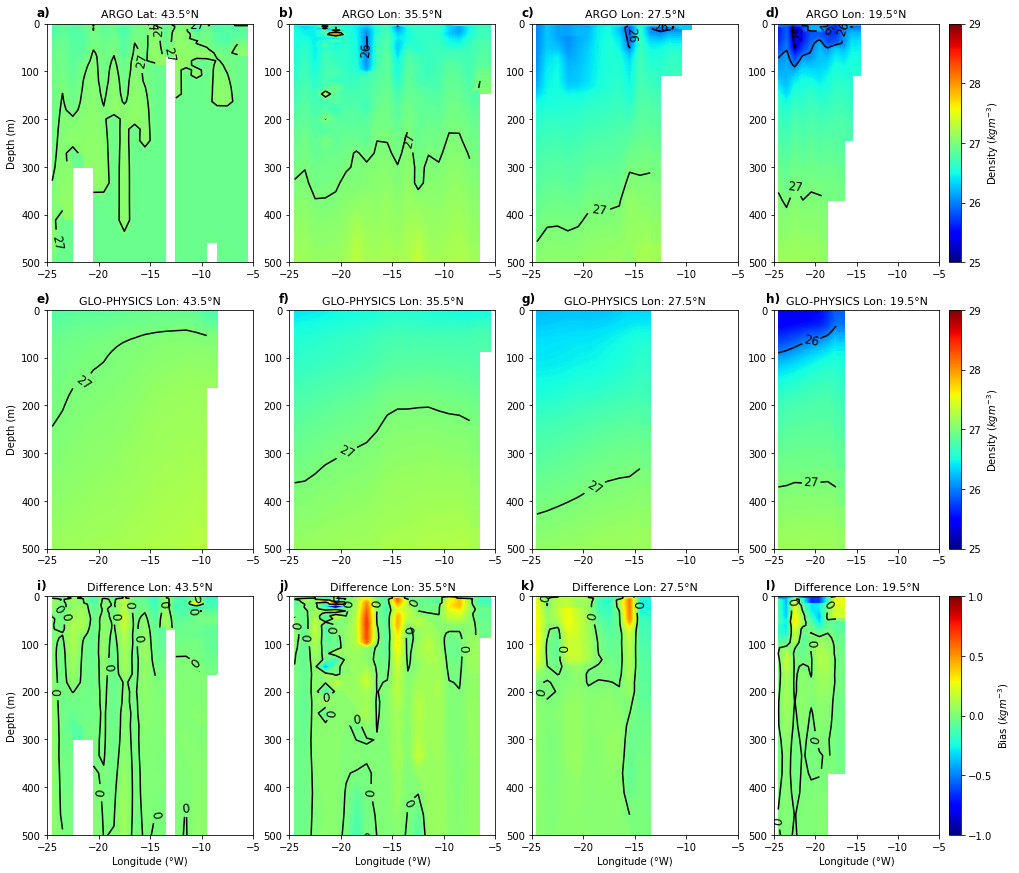

In [51]:
import string
vmins= [25]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [29]*8 + [1]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([25,26,27,28,29]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

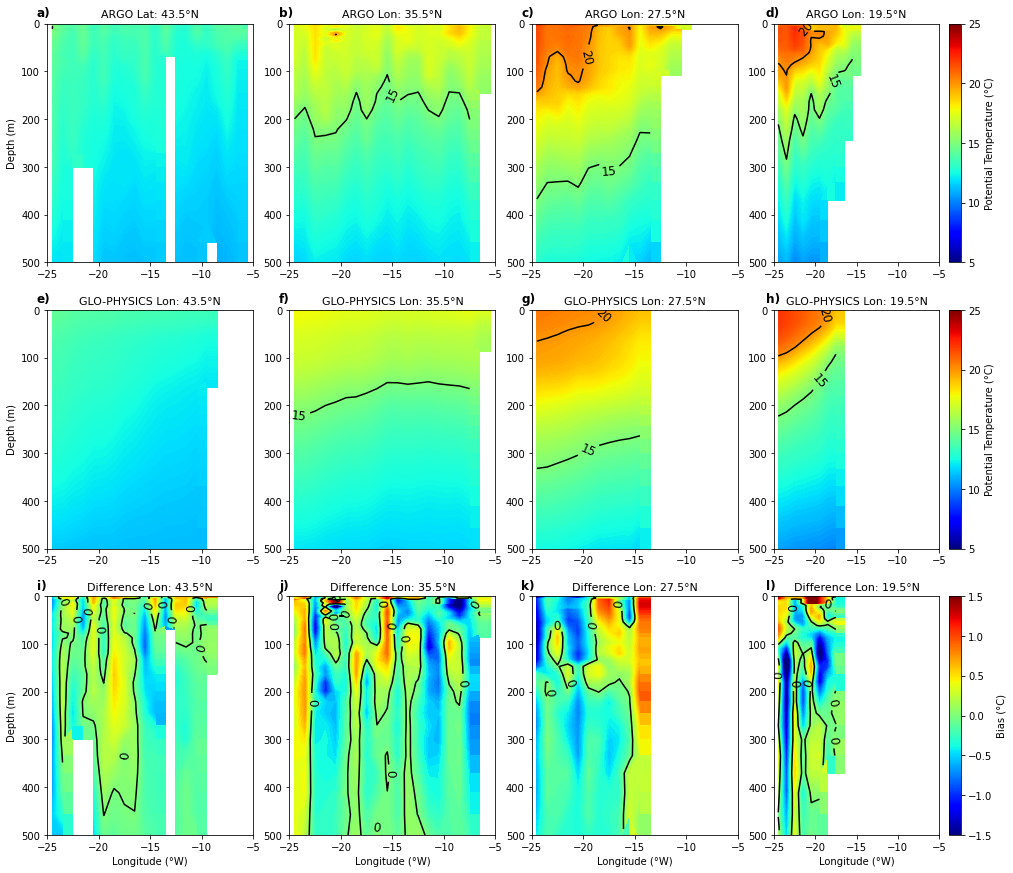

In [52]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

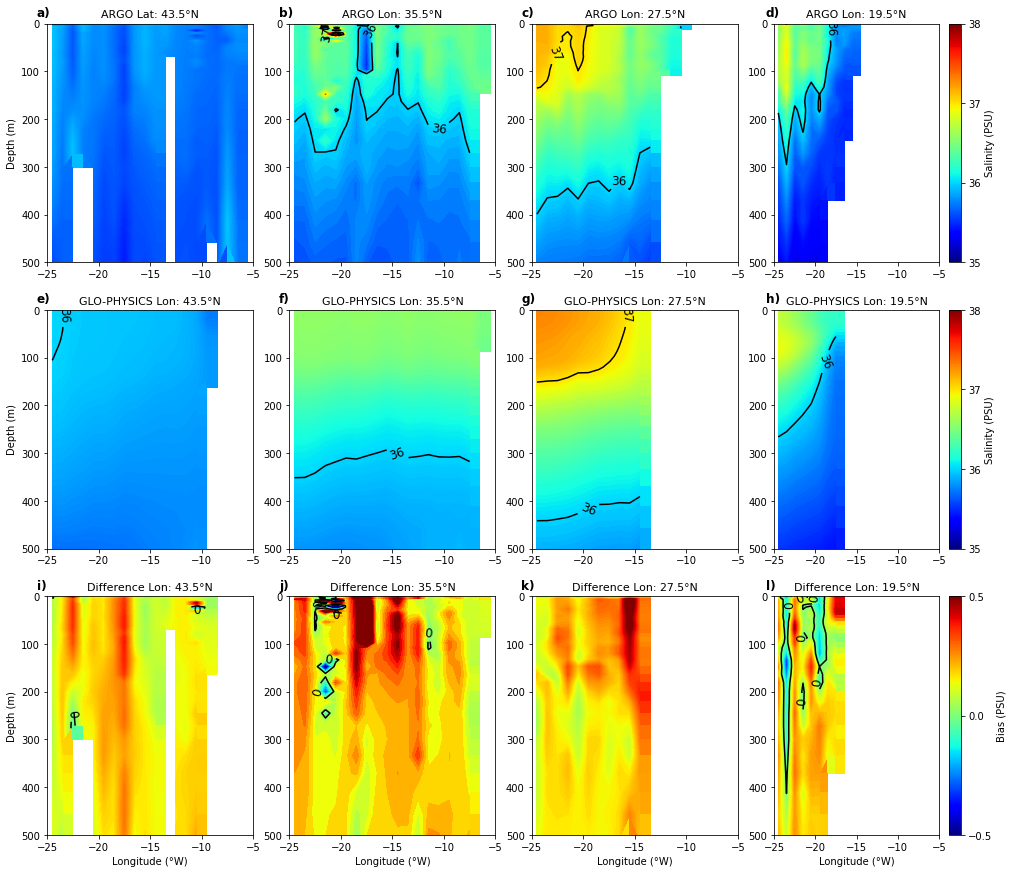

In [53]:
import string
vmins= [35]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [38]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[35,36,37,38]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([35,36,37,38]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Diagramas de Taylor

In [54]:
STD_D=[];CORRCOEF_D=[];RMSE_D=[]
STD_S=[];CORRCOEF_S=[];RMSE_S=[]
STD_T=[];CORRCOEF_T=[];RMSE_T=[]
for i in range(40):
  ###### DEN ######
  modelo= np.flipud(M_final.D.values[i,:,:]).flatten()
  satelite= A_final.D.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_D.append(np.ma.std(P.ravel()))
  CORRCOEF_D.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_D.append(np.sqrt(np.mean((P-A)**2)))
  ###### SAL ######
  modelo= np.flipud(M_final.S.values[i,:,:]).flatten()
  satelite= A_final.S.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_S.append(np.ma.std(P.ravel()))
  CORRCOEF_S.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_S.append(np.sqrt(np.mean((P-A)**2)))
  ###### TEMP ######
  modelo= np.flipud(M_final.T.values[i,:,:]).flatten()
  satelite= A_final.T.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_T.append(np.ma.std(P.ravel()))
  CORRCOEF_T.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_T.append(np.sqrt(np.mean((P-A)**2)))

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

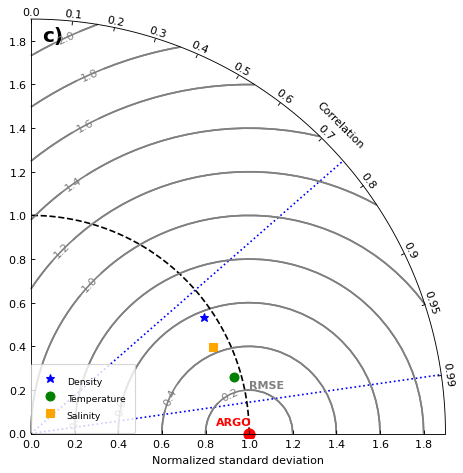

In [55]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0., 1.9), label='ARGO')
pp=[]
ttt=TayDia.add_sample(np.mean(STD_D), np.mean(CORRCOEF_D), marker="*", linestyle='None', color='blue', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_T), np.mean(CORRCOEF_T), marker="o", linestyle='None', color='green', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_S), np.mean(CORRCOEF_S), marker="s", linestyle='None', color='orange', ms=8);pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -1.25**2)],[0,1.25], color='blue',linestyle=':') # correlacion 0.75
plt.plot([0,NP.sqrt(1.9**2 -0.27**2)],[0,0.27], color='blue',linestyle=':') # correlacion 0.99
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, ['Density','Temperature','Salinity'],  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'ARGO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'c)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

## Validacion - JJA

In [56]:
JJA= interpolador_capas(dataframe= lista_dfs[2], max_depth= 600, intervalo=1)
JJA

Tamaño de los dataframes generados : 7449
(4472642, 6)


Lon     Lat  Presion_interp   D_interp   T_interp   S_interp
0       -24.997  26.631               0  26.038660  22.471184  37.392392
1       -24.997  26.631               1  26.040834  22.451344  37.389019
2       -24.997  26.631               2  26.043008  22.431503  37.385646
3       -24.997  26.631               3  26.045182  22.411663  37.382273
4       -24.997  26.631               4  26.047357  22.391822  37.378899
...         ...     ...             ...        ...        ...        ...
4472637  -5.050  44.686             596        NaN        NaN        NaN
4472638  -5.050  44.686             597        NaN        NaN        NaN
4472639  -5.050  44.686             598        NaN        NaN        NaN
4472640  -5.050  44.686             599        NaN        NaN        NaN
4472641  -5.050  44.686             600        NaN        NaN        NaN

[4472642 rows x 6 columns]

In [57]:
import scipy
from scipy.interpolate import griddata
ds_final= JJA #pasar los resultados del dataframe anteriores
# Lista para ir guardando cada matrix latxlon
datos_jan_D = []
datos_jan_T = []
datos_jan_S = []
for i in ds_final.Presion_interp.unique()[:-1]: # voy de 5m en adelante
  capa_x=ds_final[ds_final['Presion_interp']==i]
  # Grilla generica
  gridx = np.arange(-25+0.5,-5+0.5,1)# np.arange(-85,-70+1,1)
  gridy = np.arange(15+0.5, 45+0.5,1)#np.arange(-45, -15+1,1)
  grid_x, grid_y =scipy.meshgrid(gridx,gridy)
  points =np.array(capa_x[['Lon','Lat']])
  values_D=np.array(capa_x['D_interp'])
  values_T=np.array(capa_x['T_interp'])
  values_S=np.array(capa_x['S_interp'])
  # Interpoladores
  grid_z0_D=griddata(points,values_D, (grid_x,grid_y),method='linear')
  grid_z0_T=griddata(points,values_T, (grid_x,grid_y),method='linear')
  grid_z0_S=griddata(points,values_S, (grid_x,grid_y),method='linear')
  # Rotacion en el eje y Sur-Norte
  grid_z0_1_D=np.flip(grid_z0_D, axis=0)
  grid_z0_1_T=np.flip(grid_z0_T, axis=0)
  grid_z0_1_S=np.flip(grid_z0_S, axis=0)
  #print(grid_z0_1.shape)# Esto no es necesario despues
  datos_jan_D.append(grid_z0_1_D);datos_jan_T.append(grid_z0_1_T);datos_jan_S.append(grid_z0_1_S)
datos_D = np.stack(datos_jan_D);datos_T = np.stack(datos_jan_T);datos_S = np.stack(datos_jan_S)

In [58]:
print(datos_D.shape,datos_T.shape,datos_S.shape)

(600, 30, 20) (600, 30, 20) (600, 30, 20)


In [59]:
# Modelo data
T_DJF=np.mean(reanal.where(((reanal.month==6)|(reanal.month==7)|(reanal.month==8)), drop=True).CT.values,axis=0)
S_DJF=np.mean(reanal.where(((reanal.month==6)|(reanal.month==7)|(reanal.month==8)), drop=True).SA.values,axis=0)
D_DJF=np.mean(reanal.where(((reanal.month==6)|(reanal.month==7)|(reanal.month==8)), drop=True).D.values,axis=0)
print(T_DJF.shape, S_DJF.shape, D_DJF.shape)

(40, 121, 81) (40, 121, 81) (40, 121, 81)


In [60]:
# Interpolar a todas las capas para la misma grilla
x1= np.arange(-25+0.5, -5+0.5,1)
y1= list(np.arange(15+0.5, 45+0.5,1));y1=y1[::-1];y1= np.array(y1)
X_t, Y_t= np.meshgrid(x1,y1)
dat_D = []
dat_T = []
dat_S = []
for i in range(T_DJF.shape[0]):
  T_X=basemap.interp(datain=np.flipud(T_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  D_X=basemap.interp(datain=np.flipud(D_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  S_X=basemap.interp(datain=np.flipud(S_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  dat_D.append(D_X);dat_T.append(T_X);dat_S.append(S_X)
M_D = np.stack(dat_D);M_T = np.stack(dat_T);M_S = np.stack(dat_S)
print(M_D.shape, M_T.shape, M_S.shape)

(40, 30, 20) (40, 30, 20) (40, 30, 20)


<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -24.5 -23.5 -22.5 -21.5 -20.5 ... -8.5 -7.5 -6.5 -5.5
  * lat      (lat) float64 15.5 16.5 17.5 18.5 19.5 ... 40.5 41.5 42.5 43.5 44.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 25.4 25.29 25.25 ... 10.93 10.94 10.92
    S        (depth, lat, lon) float64 36.45 36.43 36.35 ... 35.77 35.76 35.76
    D        (depth, lat, lon) float64 24.21 24.23 24.18 ... 27.3 27.29 27.29

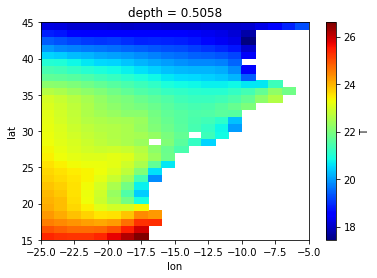

In [61]:
M_final=dt=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],M_T),"S":(['depth',"lat","lon"],M_S),"D":(['depth',"lat","lon"],M_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.arange(15+0.5, 45+0.5,1), 
                        "depth": reanal.depth.values})
M_final.T.sel(depth=M_final.depth.values[0]).plot(cmap='jet')
M_final

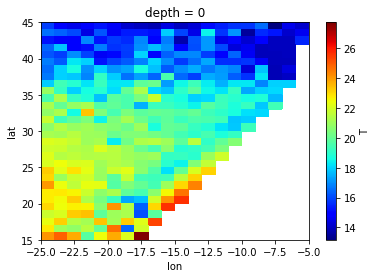

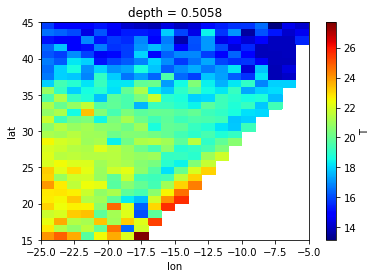

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -24.5 -23.5 -22.5 -21.5 -20.5 ... -8.5 -7.5 -6.5 -5.5
  * lat      (lat) float64 44.5 43.5 42.5 41.5 40.5 ... 19.5 18.5 17.5 16.5 15.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 15.87 14.9 14.96 14.79 ... nan nan nan
    S        (depth, lat, lon) float64 35.98 35.84 35.74 35.77 ... nan nan nan
    D        (depth, lat, lon) float64 26.59 26.7 26.6 26.67 ... nan nan nan nan

In [62]:
A_no_interp=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.array(list(np.arange(15+0.5, 45+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)})
A_final=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.array(list(np.arange(15+0.5, 45+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)}).interp(depth=reanal.depth.values)
A_no_interp.T.sel(depth=A_no_interp.depth.values[0]).plot(cmap='jet')
plt.show()
A_final.T.sel(depth=A_final.depth.values[0]).plot(cmap='jet')
plt.show()
A_final

### Graficas finales transectas

### Latitudinales

In [63]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lon_Y= [-23.5,-17.5,-11.5,-6.5]
for i in range(4):
  tran_lat_d=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_s=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_t=A_final.sel(lon=lon_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lon=lon_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lon=lon_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lon=lon_Y[i]).T.values
  tran_lat_dx=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_sx=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_tx=A_final.sel(lon=lon_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(np.flip(tran_lat_M_d,axis=1));lista_ARGOX_LAT_D.append(np.flip((M_final.sel(lon=lon_Y[i]).D-A_final.sel(lon=lon_Y[i]).D).values,axis=1))
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(np.flip(tran_lat_M_s,axis=1));lista_ARGOX_LAT_S.append(np.flip((M_final.sel(lon=lon_Y[i]).S-A_final.sel(lon=lon_Y[i]).S).values,axis=1))
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(np.flip(tran_lat_M_t,axis=1));lista_ARGOX_LAT_T.append(np.flip((M_final.sel(lon=lon_Y[i]).T-A_final.sel(lon=lon_Y[i]).T).values,axis=1))
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

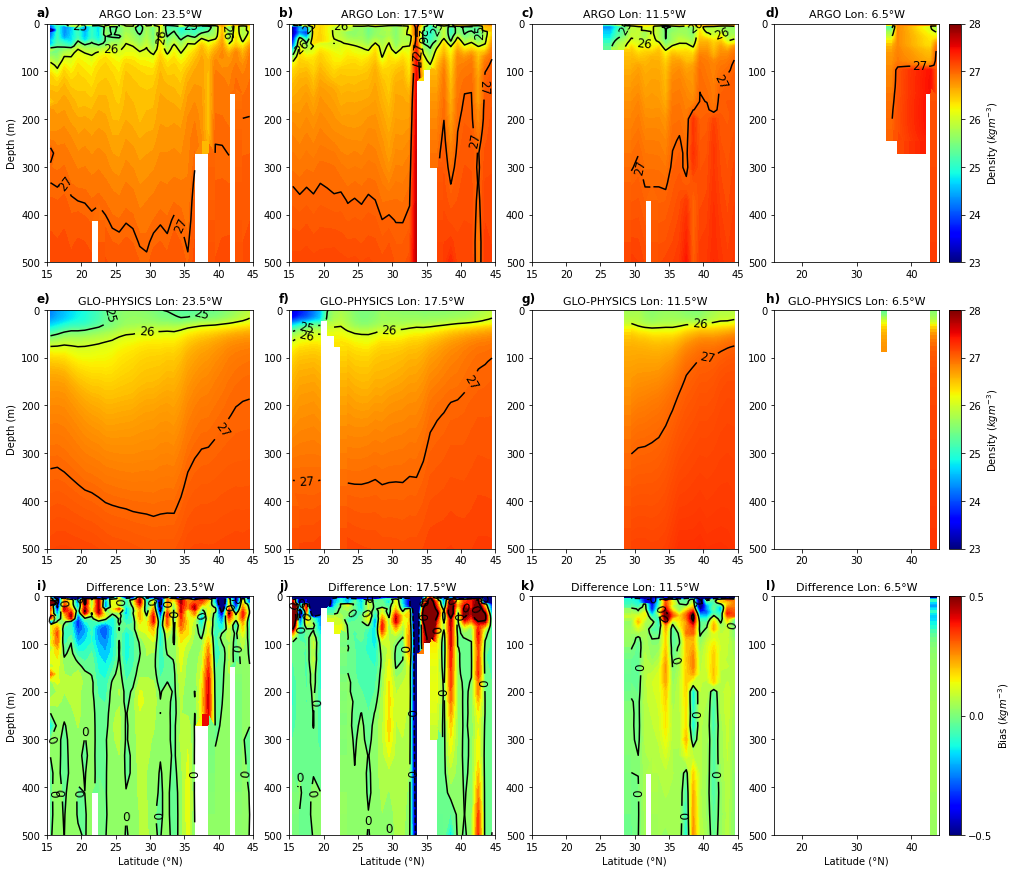

In [64]:
import string
vmins= [23]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [28]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[-0.5,0,0.5]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

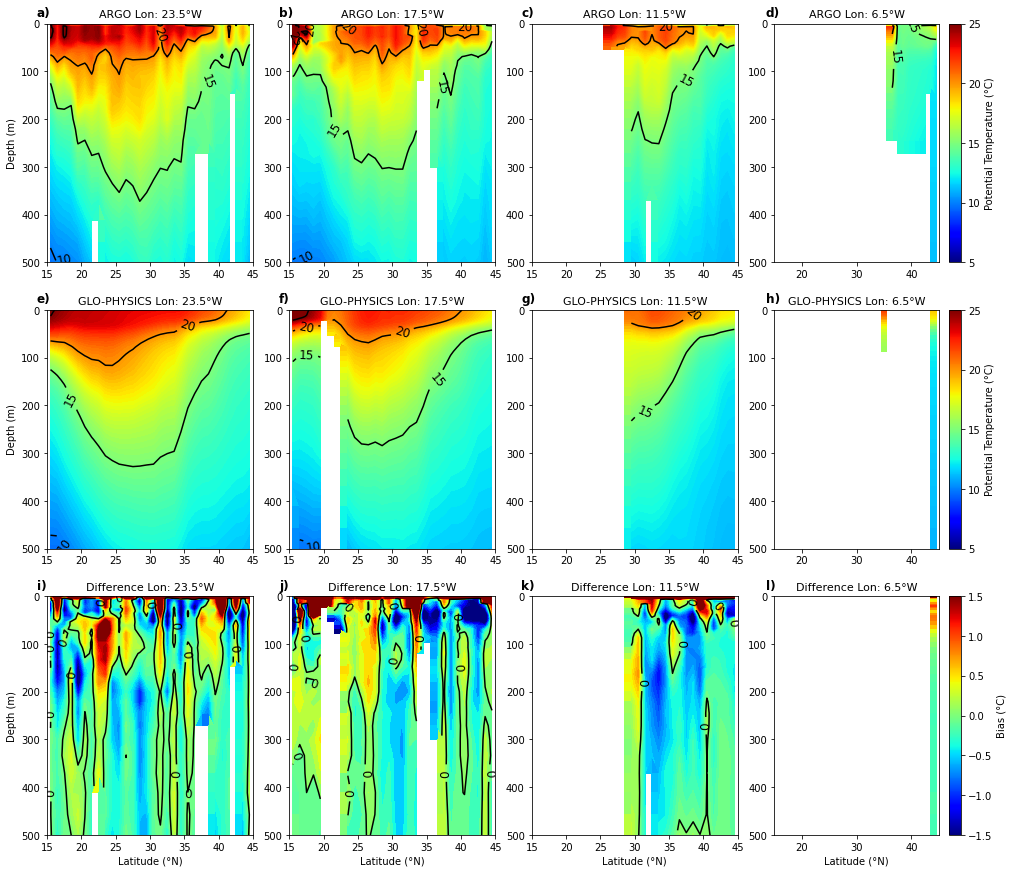

In [65]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

In [ ]:
np.nanmax(lista_final_S[0]),np.nanmin(lista_final_S[0])

(37.3732567090624, 35.09298886601711)

**Salinidad**

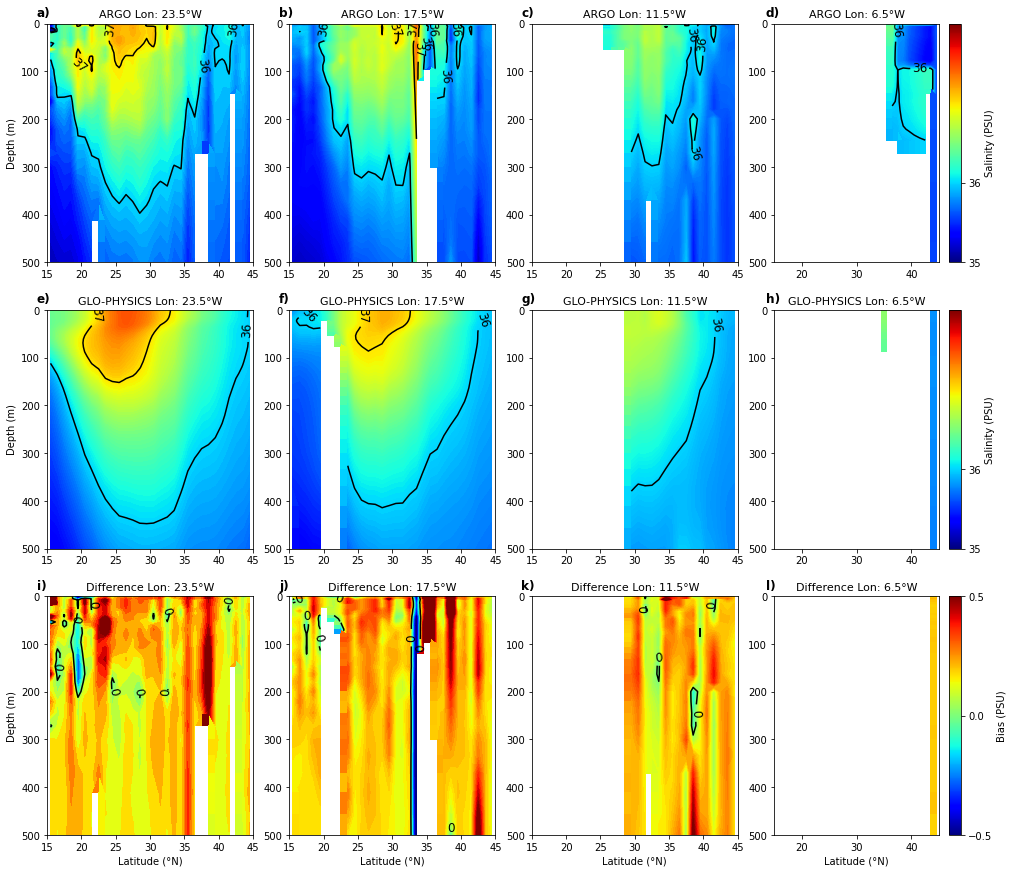

In [66]:
import string
vmins= [35]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [38]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[35,36,37,38]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Longitudinales

In [67]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lat_Y= [43.5,35.5,27.5,19.5]
for i in range(4):
  tran_lat_d=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_s=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_t=A_final.sel(lat=lat_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lat=lat_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lat=lat_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lat=lat_Y[i]).T.values
  tran_lat_dx=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_sx=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_tx=A_final.sel(lat=lat_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(tran_lat_M_d);lista_ARGOX_LAT_D.append((M_final.sel(lat=lat_Y[i]).D-A_final.sel(lat=lat_Y[i]).D).values)
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(tran_lat_M_s);lista_ARGOX_LAT_S.append((M_final.sel(lat=lat_Y[i]).S-A_final.sel(lat=lat_Y[i]).S).values)
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(tran_lat_M_t);lista_ARGOX_LAT_T.append((M_final.sel(lat=lat_Y[i]).T-A_final.sel(lat=lat_Y[i]).T).values)
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_D[0][lista_final_D[0]>27.10728928778205]= 27.10728928778205-0.2
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_S[0][lista_final_S[0]>36]= 36-0.4
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

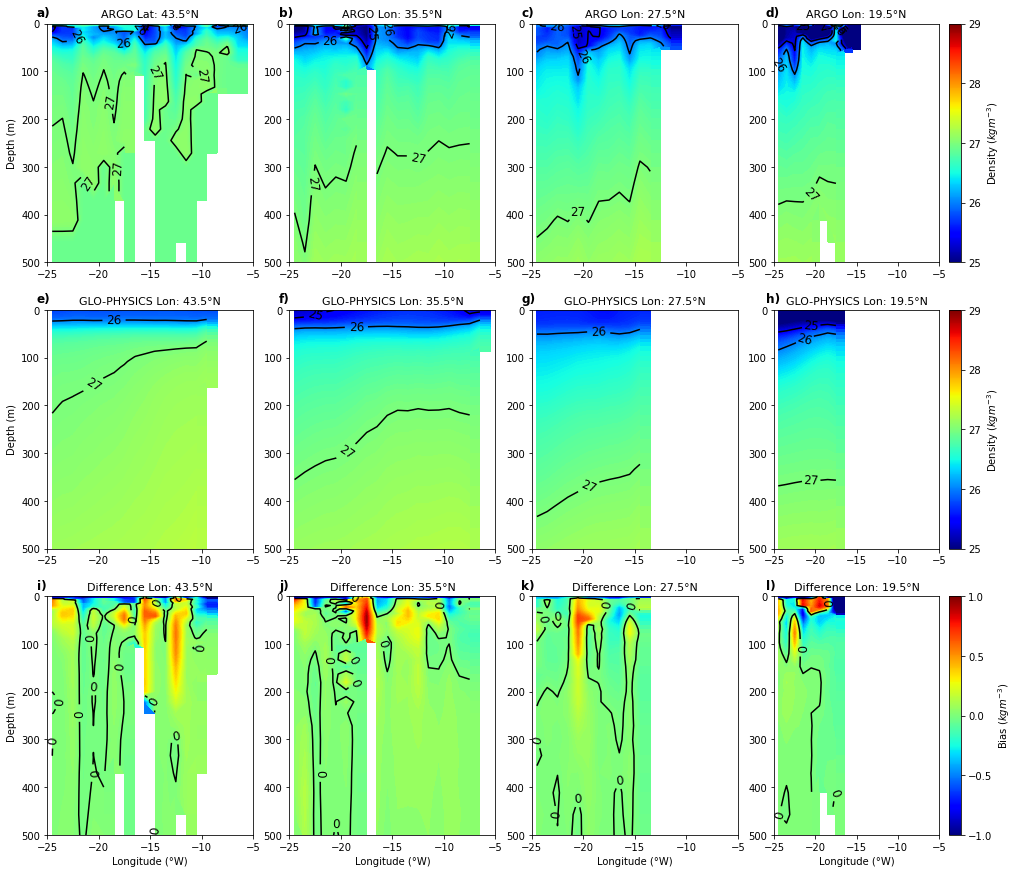

In [68]:
import string
vmins= [25]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [29]*8 + [1]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([25,26,27,28,29]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

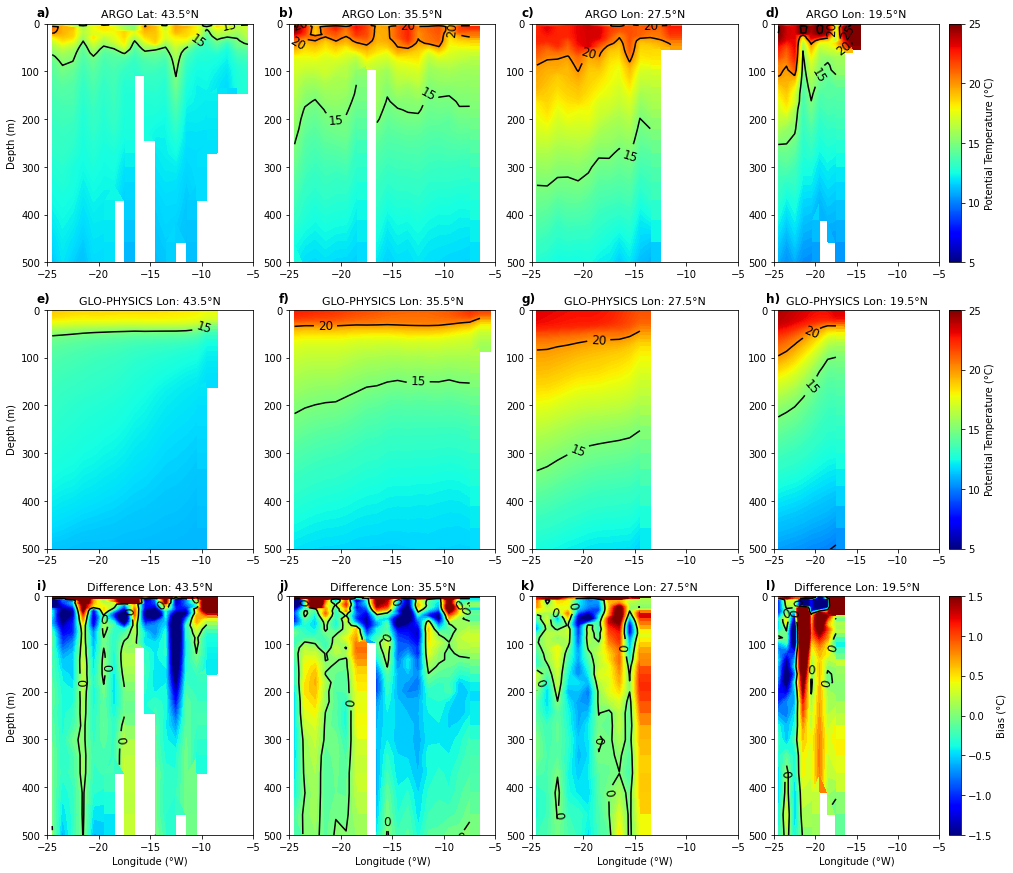

In [69]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

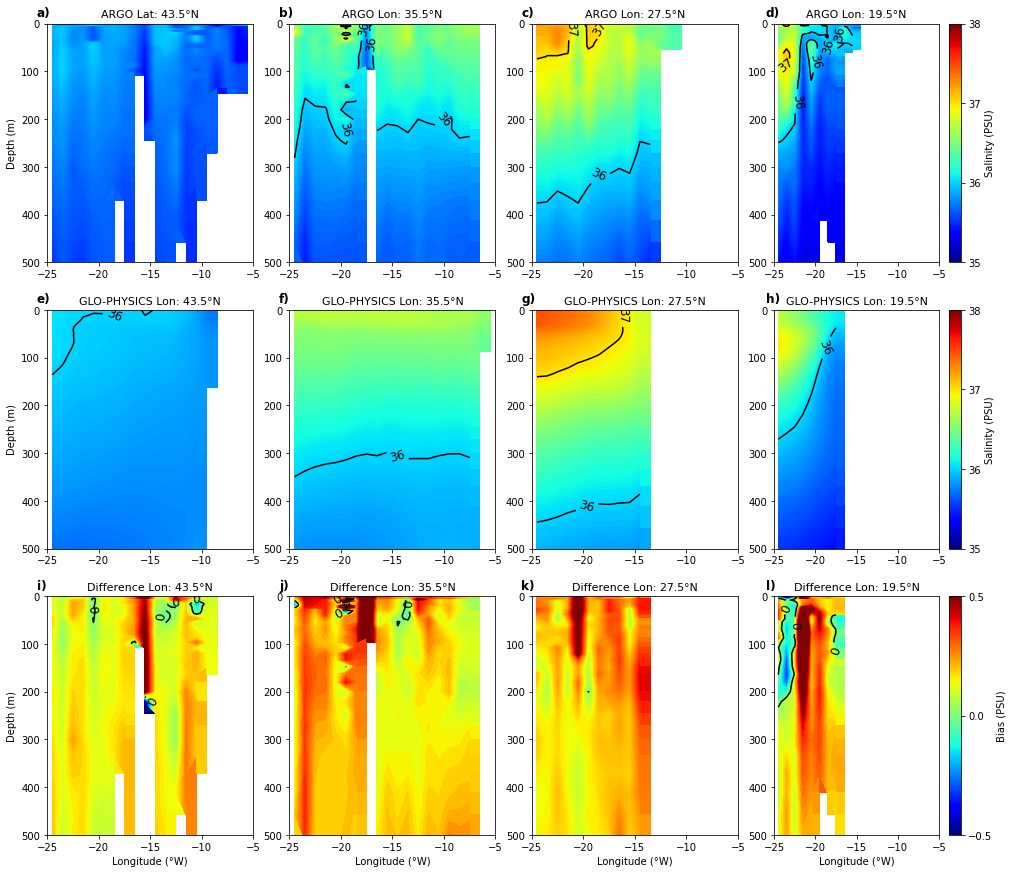

In [70]:
import string
vmins= [35]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [38]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[35,36,37,38]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([35,36,37,38]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Diagramas de Taylor

In [71]:
STD_D=[];CORRCOEF_D=[];RMSE_D=[]
STD_S=[];CORRCOEF_S=[];RMSE_S=[]
STD_T=[];CORRCOEF_T=[];RMSE_T=[]
for i in range(40):
  ###### DEN ######
  modelo= np.flipud(M_final.D.values[i,:,:]).flatten()
  satelite= A_final.D.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_D.append(np.ma.std(P.ravel()))
  CORRCOEF_D.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_D.append(np.sqrt(np.mean((P-A)**2)))
  ###### SAL ######
  modelo= np.flipud(M_final.S.values[i,:,:]).flatten()
  satelite= A_final.S.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_S.append(np.ma.std(P.ravel()))
  CORRCOEF_S.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_S.append(np.sqrt(np.mean((P-A)**2)))
  ###### TEMP ######
  modelo= np.flipud(M_final.T.values[i,:,:]).flatten()
  satelite= A_final.T.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_T.append(np.ma.std(P.ravel()))
  CORRCOEF_T.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_T.append(np.sqrt(np.mean((P-A)**2)))

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

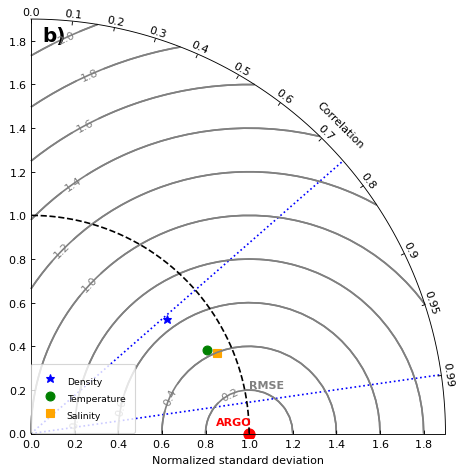

In [72]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0., 1.9), label='ARGO')
pp=[]
ttt=TayDia.add_sample(np.mean(STD_D), np.mean(CORRCOEF_D)+0.05, marker="*", linestyle='None', color='blue', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_T), np.mean(CORRCOEF_T), marker="o", linestyle='None', color='green', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_S), np.mean(CORRCOEF_S)+0.04, marker="s", linestyle='None', color='orange', ms=8);pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -1.25**2)],[0,1.25], color='blue',linestyle=':') # correlacion 0.75
plt.plot([0,NP.sqrt(1.9**2 -0.27**2)],[0,0.27], color='blue',linestyle=':') # correlacion 0.99
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, ['Density','Temperature','Salinity'],  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'ARGO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'b)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

## Validacion-SON

In [73]:
SON= interpolador_capas(dataframe= lista_dfs[3], max_depth= 600, intervalo=1)
SON

Tamaño de los dataframes generados : 7019
(4218419, 6)


Lon     Lat  Presion_interp   D_interp   T_interp   S_interp
0       -25.00  30.130               0  26.059324  21.070554  36.950983
1       -25.00  30.130               1  26.061511  21.053254  36.948495
2       -25.00  30.130               2  26.063698  21.035953  36.946007
3       -25.00  30.130               3  26.065884  21.018652  36.943519
4       -25.00  30.130               4  25.935019  21.404000  36.978110
...        ...     ...             ...        ...        ...        ...
4218414  -5.01  44.873             596        NaN        NaN        NaN
4218415  -5.01  44.873             597        NaN        NaN        NaN
4218416  -5.01  44.873             598        NaN        NaN        NaN
4218417  -5.01  44.873             599        NaN        NaN        NaN
4218418  -5.01  44.873             600        NaN        NaN        NaN

[4218419 rows x 6 columns]

In [74]:
import scipy
from scipy.interpolate import griddata
ds_final= SON #pasar los resultados del dataframe anteriores
# Lista para ir guardando cada matrix latxlon
datos_jan_D = []
datos_jan_T = []
datos_jan_S = []
for i in ds_final.Presion_interp.unique()[:-1]: # voy de 5m en adelante
  capa_x=ds_final[ds_final['Presion_interp']==i]
  # Grilla generica
  gridx = np.arange(-25+0.5,-5+0.5,1)# np.arange(-85,-70+1,1)
  gridy = np.arange(15+0.5, 45+0.5,1)#np.arange(-45, -15+1,1)
  grid_x, grid_y =scipy.meshgrid(gridx,gridy)
  points =np.array(capa_x[['Lon','Lat']])
  values_D=np.array(capa_x['D_interp'])
  values_T=np.array(capa_x['T_interp'])
  values_S=np.array(capa_x['S_interp'])
  # Interpoladores
  grid_z0_D=griddata(points,values_D, (grid_x,grid_y),method='linear')
  grid_z0_T=griddata(points,values_T, (grid_x,grid_y),method='linear')
  grid_z0_S=griddata(points,values_S, (grid_x,grid_y),method='linear')
  # Rotacion en el eje y Sur-Norte
  grid_z0_1_D=np.flip(grid_z0_D, axis=0)
  grid_z0_1_T=np.flip(grid_z0_T, axis=0)
  grid_z0_1_S=np.flip(grid_z0_S, axis=0)
  #print(grid_z0_1.shape)# Esto no es necesario despues
  datos_jan_D.append(grid_z0_1_D);datos_jan_T.append(grid_z0_1_T);datos_jan_S.append(grid_z0_1_S)
datos_D = np.stack(datos_jan_D);datos_T = np.stack(datos_jan_T);datos_S = np.stack(datos_jan_S)

In [75]:
print(datos_D.shape,datos_T.shape,datos_S.shape)

(600, 30, 20) (600, 30, 20) (600, 30, 20)


In [76]:
# Modelo data
T_DJF=np.mean(reanal.where(((reanal.month==9)|(reanal.month==10)|(reanal.month==11)), drop=True).CT.values,axis=0)
S_DJF=np.mean(reanal.where(((reanal.month==9)|(reanal.month==10)|(reanal.month==11)), drop=True).SA.values,axis=0)
D_DJF=np.mean(reanal.where(((reanal.month==9)|(reanal.month==10)|(reanal.month==11)), drop=True).D.values,axis=0)
print(T_DJF.shape, S_DJF.shape, D_DJF.shape)

(40, 121, 81) (40, 121, 81) (40, 121, 81)


In [77]:
# Interpolar a todas las capas para la misma grilla
x1= np.arange(-25+0.5, -5+0.5,1)
y1= list(np.arange(15+0.5, 45+0.5,1));y1=y1[::-1];y1= np.array(y1)
X_t, Y_t= np.meshgrid(x1,y1)
dat_D = []
dat_T = []
dat_S = []
for i in range(T_DJF.shape[0]):
  T_X=basemap.interp(datain=np.flipud(T_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  D_X=basemap.interp(datain=np.flipud(D_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  S_X=basemap.interp(datain=np.flipud(S_DJF[i,:,:]), xin=reanal.lon.values,
                       yin=reanal.lat.values,xout=X_t, yout=Y_t, order=1, masked= True)
  dat_D.append(D_X);dat_T.append(T_X);dat_S.append(S_X)
M_D = np.stack(dat_D);M_T = np.stack(dat_T);M_S = np.stack(dat_S)
print(M_D.shape, M_T.shape, M_S.shape)

(40, 30, 20) (40, 30, 20) (40, 30, 20)


<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -24.5 -23.5 -22.5 -21.5 -20.5 ... -8.5 -7.5 -6.5 -5.5
  * lat      (lat) float64 15.5 16.5 17.5 18.5 19.5 ... 40.5 41.5 42.5 43.5 44.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 27.02 27.04 27.3 ... 10.97 10.97 10.95
    S        (depth, lat, lon) float64 36.48 36.44 36.3 ... 35.77 35.76 35.76
    D        (depth, lat, lon) float64 23.73 23.68 23.5 ... 27.29 27.29 27.29

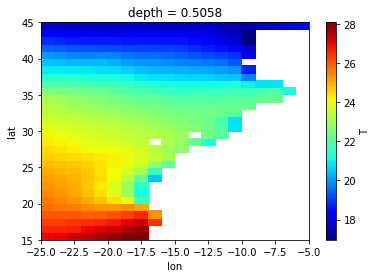

In [78]:
M_final=dt=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],M_T),"S":(['depth',"lat","lon"],M_S),"D":(['depth',"lat","lon"],M_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.arange(15+0.5, 45+0.5,1), 
                        "depth": reanal.depth.values})
M_final.T.sel(depth=M_final.depth.values[0]).plot(cmap='jet')
M_final

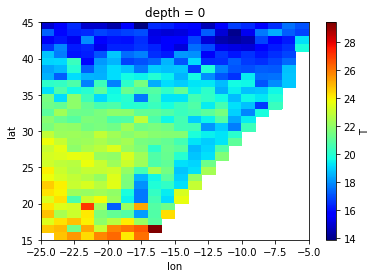

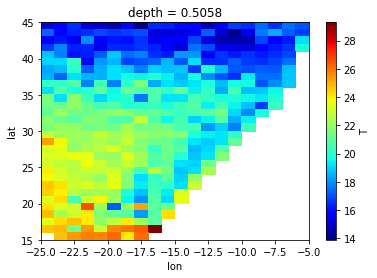

<xarray.Dataset>
Dimensions:  (depth: 40, lat: 30, lon: 20)
Coordinates:
  * lon      (lon) float64 -24.5 -23.5 -22.5 -21.5 -20.5 ... -8.5 -7.5 -6.5 -5.5
  * lat      (lat) float64 44.5 43.5 42.5 41.5 40.5 ... 19.5 18.5 17.5 16.5 15.5
  * depth    (depth) float32 0.5058 1.556 2.668 3.856 ... 411.8 457.6 508.6
Data variables:
    T        (depth, lat, lon) float64 14.99 15.68 16.49 14.99 ... nan nan nan
    S        (depth, lat, lon) float64 35.86 35.93 36.01 35.85 ... nan nan nan
    D        (depth, lat, lon) float64 26.7 26.6 26.46 26.69 ... nan nan nan nan

In [79]:
A_no_interp=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.array(list(np.arange(15+0.5, 45+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)})
A_final=xr.Dataset(data_vars={"T":(['depth',"lat","lon"],datos_T),"S":(['depth',"lat","lon"],datos_S),"D":(['depth',"lat","lon"],datos_D)}, 
                coords={"lon": np.arange(-25+0.5, -5+0.5,1), 
                        "lat": np.array(list(np.arange(15+0.5, 45+0.5,1))[::-1]), 
                        "depth": np.arange(0,600,1)}).interp(depth=reanal.depth.values)
A_no_interp.T.sel(depth=A_no_interp.depth.values[0]).plot(cmap='jet')
plt.show()
A_final.T.sel(depth=A_final.depth.values[0]).plot(cmap='jet')
plt.show()
A_final

### Graficas finales transectas

### Latitudinales

In [80]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lon_Y= [-23.5,-17.5,-11.5,-6.5]
for i in range(4):
  tran_lat_d=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_s=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_t=A_final.sel(lon=lon_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lon=lon_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lon=lon_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lon=lon_Y[i]).T.values
  tran_lat_dx=A_final.sel(lon=lon_Y[i]).D.values;tran_lat_sx=A_final.sel(lon=lon_Y[i]).S.values;tran_lat_tx=A_final.sel(lon=lon_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(np.flip(tran_lat_M_d,axis=1));lista_ARGOX_LAT_D.append(np.flip((M_final.sel(lon=lon_Y[i]).D-A_final.sel(lon=lon_Y[i]).D).values,axis=1))
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(np.flip(tran_lat_M_s,axis=1));lista_ARGOX_LAT_S.append(np.flip((M_final.sel(lon=lon_Y[i]).S-A_final.sel(lon=lon_Y[i]).S).values,axis=1))
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(np.flip(tran_lat_M_t,axis=1));lista_ARGOX_LAT_T.append(np.flip((M_final.sel(lon=lon_Y[i]).T-A_final.sel(lon=lon_Y[i]).T).values,axis=1))
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

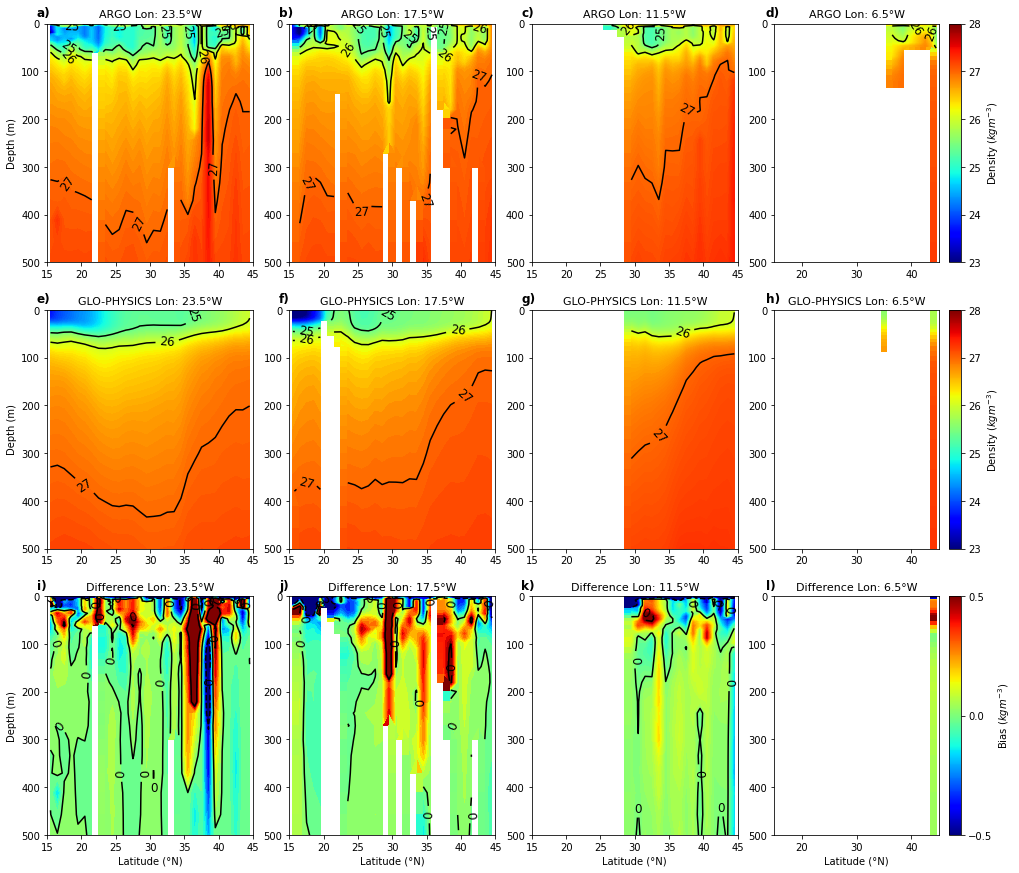

In [81]:
import string
vmins= [23]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [28]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[-0.5,0,0.5]]*4 #niveles a mostrar en el colorbar
ticks= np.array([23,24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

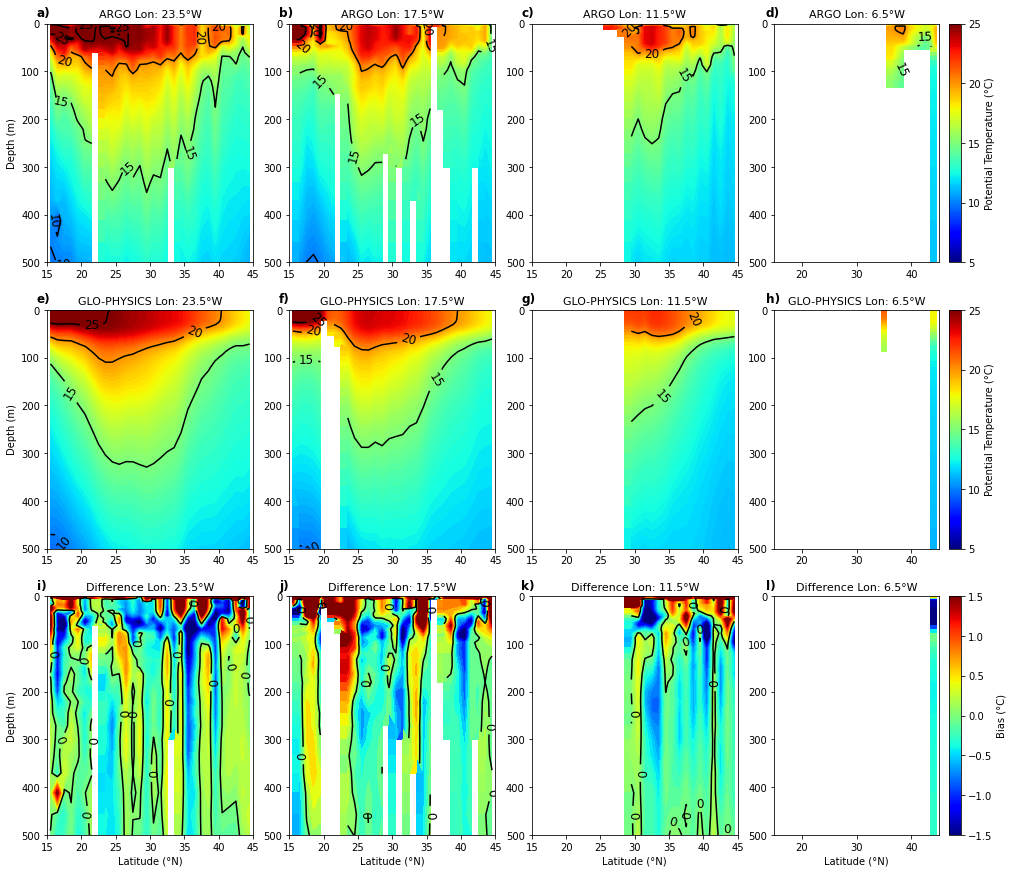

In [82]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

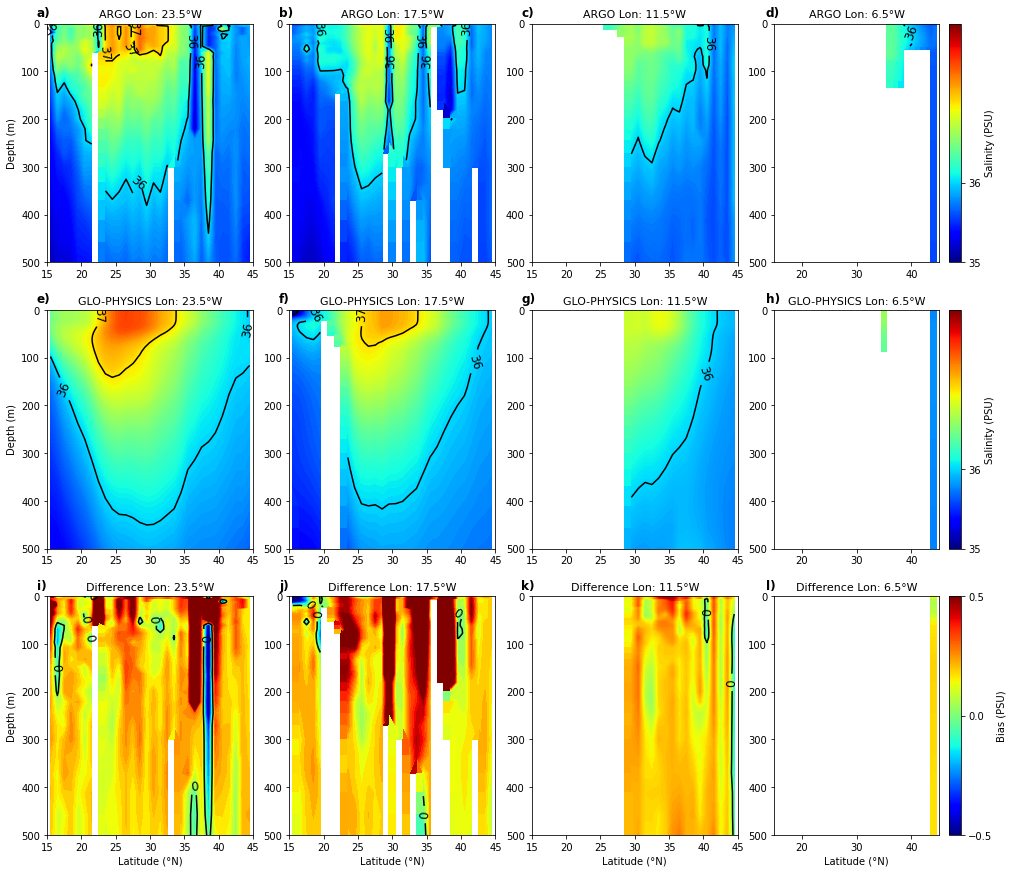

In [83]:
import string
vmins= [35]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [38]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[35,36,37,38]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([32,33,34,35,36]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [yt1]*4;lista_yt_ARGOX= [yt1]*4;lista_yt_M= [yt1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lon: 23.5°W','ARGO Lon: 17.5°W','ARGO Lon: 11.5°W','ARGO Lon: 6.5°W',
       'GLO-PHYSICS Lon: 23.5°W','GLO-PHYSICS Lon: 17.5°W','GLO-PHYSICS Lon: 11.5°W','GLO-PHYSICS Lon: 6.5°W',
       'Difference Lon: 23.5°W','Difference Lon: 17.5°W','Difference Lon: 11.5°W','Difference Lon: 6.5°W',]
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([15,45]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Latitude (°N)')
  elif j in [9,10]:ax.set_xlabel('Latitude (°N)')
  elif j==11: ax.set_xlabel('Latitude (°N)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Longitudinales

In [84]:
lista_ARGO_LAT_D=[]; lista_ARGO_LAT_S=[]; lista_ARGO_LAT_T=[]
lista_MODEL_LAT_D=[];lista_MODEL_LAT_S=[];lista_MODEL_LAT_T=[]
lista_ARGOX_LAT_D=[]; lista_ARGOX_LAT_S=[]; lista_ARGOX_LAT_T=[]
# datos_D, datos_S, datos_T = datos reales de argo con 600 niveles
lat_Y= [43.5,35.5,27.5,19.5]
for i in range(4):
  tran_lat_d=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_s=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_t=A_final.sel(lat=lat_Y[i]).T.values;
  tran_lat_M_d= M_final.sel(lat=lat_Y[i]).D.values
  tran_lat_M_s= M_final.sel(lat=lat_Y[i]).S.values
  tran_lat_M_t= M_final.sel(lat=lat_Y[i]).T.values
  tran_lat_dx=A_final.sel(lat=lat_Y[i]).D.values;tran_lat_sx=A_final.sel(lat=lat_Y[i]).S.values;tran_lat_tx=A_final.sel(lat=lat_Y[i]).T.values;
  lista_ARGO_LAT_D.append(tran_lat_d);lista_MODEL_LAT_D.append(tran_lat_M_d);lista_ARGOX_LAT_D.append((M_final.sel(lat=lat_Y[i]).D-A_final.sel(lat=lat_Y[i]).D).values)
  lista_ARGO_LAT_S.append(tran_lat_s);lista_MODEL_LAT_S.append(tran_lat_M_s);lista_ARGOX_LAT_S.append((M_final.sel(lat=lat_Y[i]).S-A_final.sel(lat=lat_Y[i]).S).values)
  lista_ARGO_LAT_T.append(tran_lat_t);lista_MODEL_LAT_T.append(tran_lat_M_t);lista_ARGOX_LAT_T.append((M_final.sel(lat=lat_Y[i]).T-A_final.sel(lat=lat_Y[i]).T).values)
lista_final_D= lista_ARGO_LAT_D+lista_MODEL_LAT_D + lista_ARGOX_LAT_D# acoplar las tres listas 
lista_final_D[0][lista_final_D[0]>27.10728928778205]= 27.10728928778205-0.2
lista_final_S= lista_ARGO_LAT_S+lista_MODEL_LAT_S+ lista_ARGOX_LAT_S # acoplar las tres listas 
lista_final_S[0][lista_final_S[0]>36]= 36-0.4
lista_final_T= lista_ARGO_LAT_T+lista_MODEL_LAT_T + lista_ARGOX_LAT_T# acoplar las tres listas 
print(len(lista_final_D),len(lista_final_T),len(lista_final_S))

12 12 12


**Densidad**

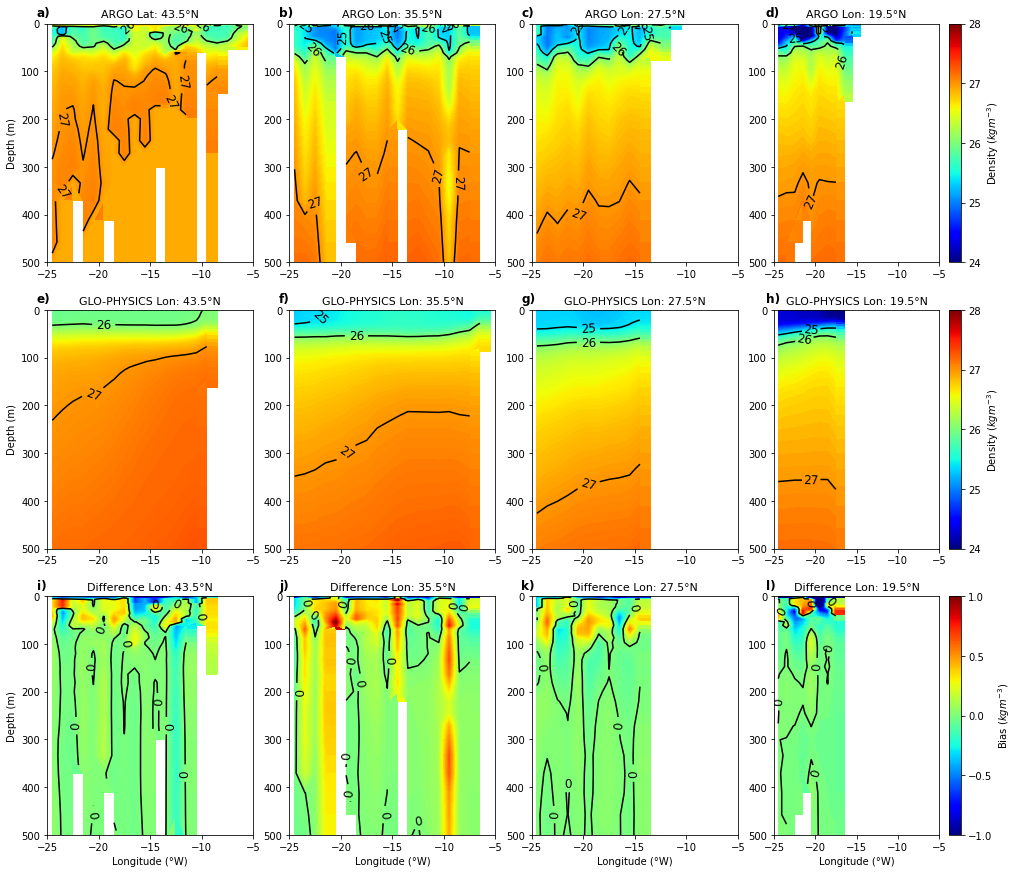

In [86]:
import string
vmins= [24]*8 + [-1]*4 #limites inferiores replicados
vmaxs= [28]*8 + [1]*4 #limites superiores replicados
levelsx=[[25.4,26,27]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([24,25,26,27,28]) #labels para el colorbar de datos
ticks_dif= np.array([-1,-0.5,0,0.5,1]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
##############################################################################################
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_D[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_D[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Density ($kg m^{-3}$)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias ($kg m^{-3}$)', rotation=90)
plt.tight_layout()

**Temperatura**

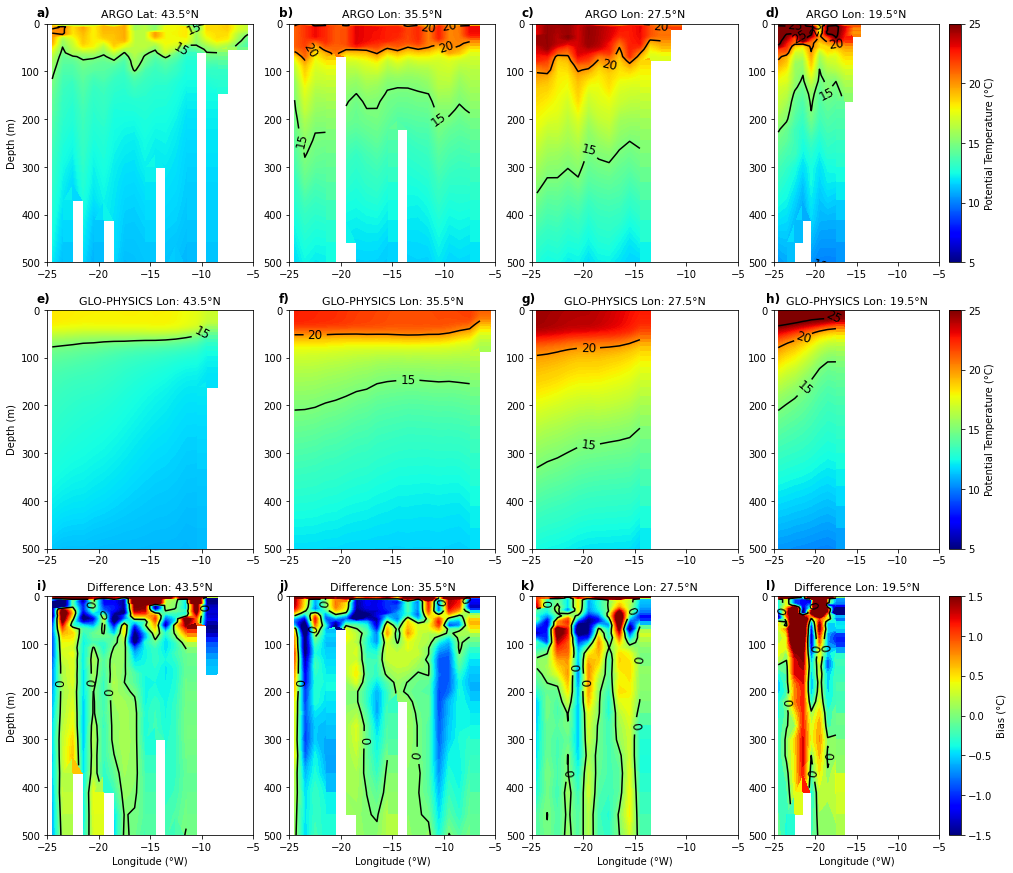

In [87]:
import string
vmins= [5]*8 + [-1.5]*4 #limites inferiores replicados
vmaxs= [25]*8 + [1.5]*4 #limites superiores replicados
levelsx=[[5,10,15,20,25]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([5,10,15,20,25]) #labels para el colorbar de datos
ticks_dif= np.array([-1.5,-1,-0.5,0,0.5,1,1.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_T[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_T[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Potential Temperature (°C)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (°C)', rotation=90)
plt.tight_layout()

**Salinidad**

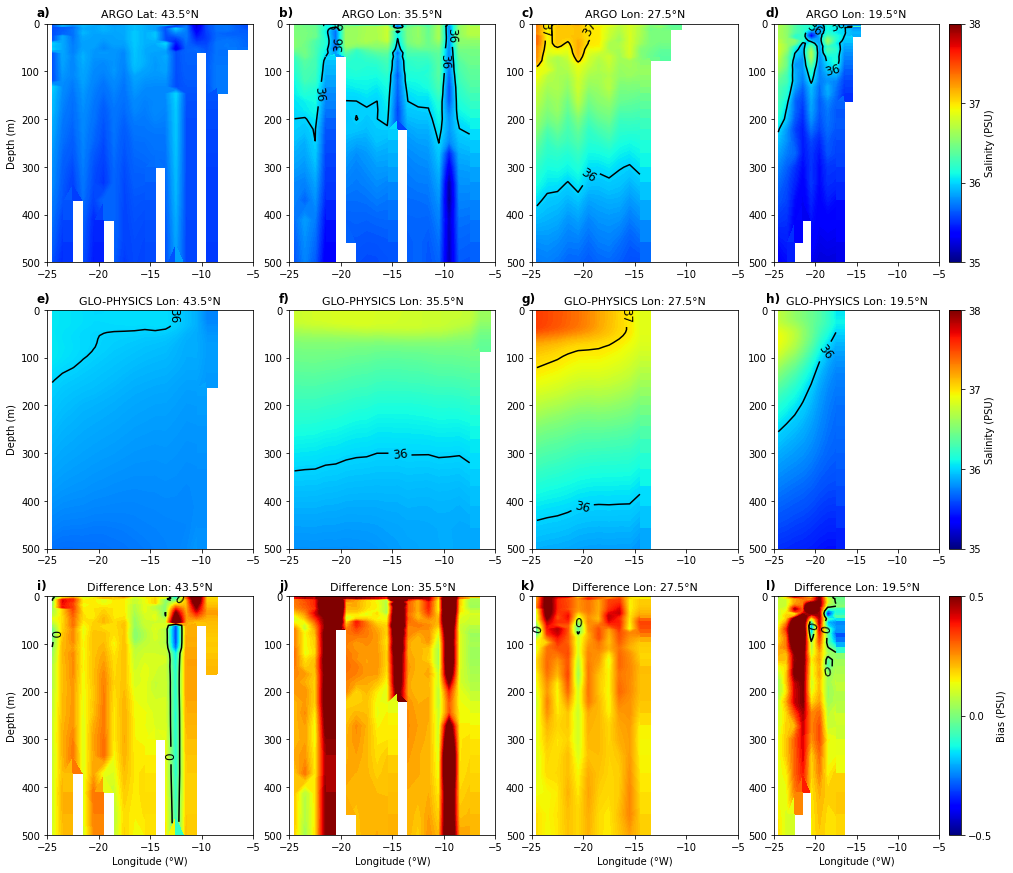

In [88]:
import string
vmins= [35]*8 + [-0.5]*4 #limites inferiores replicados
vmaxs= [38]*8 + [0.5]*4 #limites superiores replicados
levelsx=[[35,36,37,38]]*8 +[[0]]*4 #niveles a mostrar en el colorbar
ticks= np.array([35,36,37,38]) #labels para el colorbar de datos
ticks_dif= np.array([-0.5,0,0.5]) # ticks para colorbar de diferencia
prof= np.arange(0,600,1) # profundidades argo
prof_M= reanal.depth.values # profundidades modelo
lista_prof_ARGO=[prof_M]*4;lista_prof_ARGOX=[prof_M]*4;lista_prof_M=[prof_M]*4
lista_profs = lista_prof_ARGO + lista_prof_M +lista_prof_ARGOX
xts1=X_t[0,:]; yt1=Y_t[:,0] # coordenadas
lista_yt_ARGO= [xts1]*4;lista_yt_ARGOX= [xts1]*4;lista_yt_M= [xts1]*4
lista_yts=lista_yt_ARGO + lista_yt_M + lista_yt_ARGOX # agregar las tres listas
w=0.17;h=0.15
meses=['ARGO Lat: 43.5°N','ARGO Lon: 35.5°N','ARGO Lon: 27.5°N','ARGO Lon: 19.5°N',
       'GLO-PHYSICS Lon: 43.5°N','GLO-PHYSICS Lon: 35.5°N','GLO-PHYSICS Lon: 27.5°N','GLO-PHYSICS Lon: 19.5°N',
       'Difference Lon: 43.5°N','Difference Lon: 35.5°N','Difference Lon: 27.5°N','Difference Lon: 19.5°N']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.83,w,h],[0.2,0.83,w,h],[0.4,0.83,w,h],[0.6,0.83,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.47,w,h],[0.2,0.47,w,h],[0.4,0.47,w,h],[0.6,0.47,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(-0.05,1.03,string.ascii_lowercase[j]+')',fontsize=12, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=11)
  # para la barra de colores
  cbar=ax.pcolormesh(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], shading='flat')
  # para generar los contornos suavizados
  ax.contourf(lista_yts[j],lista_profs[j],lista_final_S[j],cmap='jet',vmin=vmins[j], vmax=vmaxs[j], levels=100)
  cs=ax.contour(lista_yts[j],lista_profs[j],lista_final_S[j], levels=levelsx[j],colors='k')
  plt.clabel(cs,inline=True, fmt='%1.0f',fontsize=12, colors='k')
  ax.set_ylim([0,500]);ax.set_xlim([-25,-5]);plt.margins(x=0)
  plt.gca().invert_yaxis()
  if j==0:ax.set_ylabel('Depth (m)')
  elif j==3:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==4:ax.set_ylabel('Depth (m)')
  elif j==7:cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks);cbar1.set_label('Salinity (PSU)', rotation=90);#ax.set_xlabel('Latitude (°S)')
  elif j==8:ax.set_ylabel('Depth (m)');ax.set_xlabel('Longitude (°W)')
  elif j in [9,10]:ax.set_xlabel('Longitude (°W)')
  elif j==11: ax.set_xlabel('Longitude (°W)');cbar1=plt.colorbar(cbar, ax=ax, ticks=ticks_dif);cbar1.set_label('Bias (PSU)', rotation=90)
plt.tight_layout()

### Diagramas de Taylor

In [89]:
STD_D=[];CORRCOEF_D=[];RMSE_D=[]
STD_S=[];CORRCOEF_S=[];RMSE_S=[]
STD_T=[];CORRCOEF_T=[];RMSE_T=[]
for i in range(40):
  ###### DEN ######
  modelo= np.flipud(M_final.D.values[i,:,:]).flatten()
  satelite= A_final.D.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_D.append(np.ma.std(P.ravel()))
  CORRCOEF_D.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_D.append(np.sqrt(np.mean((P-A)**2)))
  ###### SAL ######
  modelo= np.flipud(M_final.S.values[i,:,:]).flatten()
  satelite= A_final.S.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_S.append(np.ma.std(P.ravel()))
  CORRCOEF_S.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_S.append(np.sqrt(np.mean((P-A)**2)))
  ###### TEMP ######
  modelo= np.flipud(M_final.T.values[i,:,:]).flatten()
  satelite= A_final.T.values[i,:,:].flatten() # aplicar media en dimension tiempo
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo)) # Sacar los indices que comparten en el espacio
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_T.append(np.ma.std(P.ravel()))
  CORRCOEF_T.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE_T.append(np.sqrt(np.mean((P-A)**2)))

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


Text(1.0, 0.21, 'RMSE')

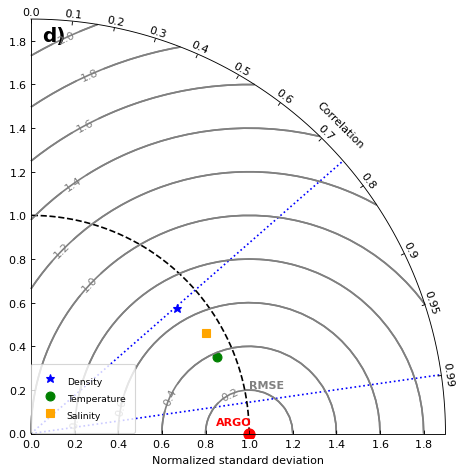

In [90]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0., 1.9), label='ARGO')
pp=[]
ttt=TayDia.add_sample(np.mean(STD_D), np.mean(CORRCOEF_D)+0.02, marker="*", linestyle='None', color='blue', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_T), np.mean(CORRCOEF_T), marker="o", linestyle='None', color='green', ms=8);pp.append(ttt)
ttt=TayDia.add_sample(np.mean(STD_S), np.mean(CORRCOEF_S), marker="s", linestyle='None', color='orange', ms=8);pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -1.25**2)],[0,1.25], color='blue',linestyle=':') # correlacion 0.75
plt.plot([0,NP.sqrt(1.9**2 -0.27**2)],[0,0.27], color='blue',linestyle=':') # correlacion 0.99
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, ['Density','Temperature','Salinity'],  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'ARGO', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'d)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')